In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format  # Sets float precision to 3 decimal places.

# Data Visualisation Libraries
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

!pip install seaborn --upgrade
import seaborn as sns
sns.set_style('darkgrid')

# Statistics
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

print('✔️ Libraries Imported!')


✔️ Libraries Imported!


In [ ]:
font_size = 20
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

colors = ['#00A5E0', '#DD403A']
colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

random_state = 42
scoring_metric = 'recall'
comparison_dict, comparison_test_dict = {}, {}

print('✔️ Default Parameters and Variables Set!')

✔️ Default Parameters and Variables Set!


In [ ]:
def plot_continuous(feature):
    '''Plot a histogram and boxplot for the churned and retained distributions for the specified feature.'''
    df_func = train_df.copy()
    df_func['Exited'] = df_func['Exited'].astype('category')

    fig, (ax1, ax2) = plt.subplots(2,
                                   figsize=(9, 7),
                                   sharex=True,
                                   gridspec_kw={'height_ratios': (.7, .3)})

    for df, color, label in zip([df_retained, df_churned], colors, ['Retained', 'Churned']):
        sns.histplot(data=df,
                     x=feature,
                     bins=15,
                     color=color,
                     alpha=0.66,
                     edgecolor='firebrick',
                     label=label,
                     kde=False,
                     ax=ax1)
    ax1.legend()

    sns.boxplot(x=feature, y='Exited', data=df_func, palette=colors, ax=ax2)
    ax2.set_ylabel('')
    ax2.set_yticklabels(['Retained', 'Churned'])

    plt.tight_layout();


print('✔️ Function Defined!')

✔️ Function Defined!


In [ ]:
def plot_categorical(feature):
    '''For a categorical feature, plot a seaborn.countplot for the total counts of each category next to a barplot for the churn rate.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    sns.countplot(x=feature,
                  hue='Exited',
                  data=train_df,
                  palette=colors,
                  ax=ax1)
    ax1.set_ylabel('Count')
    ax1.legend(labels=['Retained', 'Churned'])

    sns.barplot(x=feature,
                y='Exited',
                data=train_df,
                palette=colors_cat,
                ax=ax2)
    ax2.set_ylabel('Churn rate')

    if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])

    plt.tight_layout();


print('✔️ Function Defined!')

✔️ Function Defined!


In [ ]:
def plot_conf_mx(cm, ax):
    '''Plot a confusion matrix in the specified axes object.'''
    sns.heatmap(data=cm,
                annot=True,
                cmap='Blues',
                annot_kws={'fontsize': 30},
                ax=ax)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Retained', 'Churned']);


print('✔️ Function Defined!')

✔️ Function Defined!


In [ ]:
def plot_learning_curve(estimator,
                        X,
                        y,
                        ax,
                        cv=None,
                        train_sizes=np.linspace(0.1, 1.0, 5)):
    '''Plot the learning curves for an estimator in the specified axes object.'''
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1,
                    color='dodgerblue')
    ax.fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,
                    color='darkorange')

    ax.plot(train_sizes,
            train_scores_mean,
            color='dodgerblue',
            marker='o',
            linestyle='-',
            label='Training Score')
    ax.plot(train_sizes,
            test_scores_mean,
            color='darkorange',
            marker='o',
            linestyle='-',
            label='Cross-validation Score')

    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.legend(loc='best', fontsize=14);


print('✔️ Function Defined!')

✔️ Function Defined!


In [ ]:
def clf_performance(classifier, classifier_name, classifier_name_abv):
    '''Display the overall performance of a classifier with this template.'''
    print('\n', classifier_name)
    print('-------------------------------')
    print('   Best Score ({}): '.format(scoring_metric) + str(np.round(classifier.best_score_, 3)))
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items():
        print('      {}: {}'.format(key, value))

    y_pred_pp = cross_val_predict(estimator=classifier.best_estimator_,
                                  X=X_train,
                                  y=y_train,
                                  cv=5,
                                  method='predict_proba')[:, 1]
    y_pred = y_pred_pp.round()

    cm = confusion_matrix(y_train, y_pred, normalize='true')

    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    comparison_dict[classifier_name_abv] = [
        accuracy_score(y_train, y_pred),
        precision_score(y_train, y_pred),
        recall_score(y_train, y_pred),
        roc_auc_score(y_train, y_pred_pp), fpr, tpr
    ]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    plot_conf_mx(cm, ax1)
    plot_learning_curve(classifier.best_estimator_, X_train, y_train, ax2)

    plt.tight_layout();


print('✔️ Function Defined!')

✔️ Function Defined!


In [ ]:
def plot_feature_imp(classifier, classifier_name, color, ax):
    '''Plot the importance of features for a classifier as a barplot.'''
    importances = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(classifier.best_estimator_.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')

    importances.plot.barh(color=color,
                          edgecolor='firebrick',
                          legend=False,
                          ax=ax)
    ax.set_title(classifier_name)
    ax.set_xlabel('Importance');


print('✔️ Function Defined!')

✔️ Function Defined!


In [ ]:
def test_func(classifier, classifier_name, ax):
    '''Assess the performance on the test set and plot the confusion matrix.'''
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    comparison_test_dict[classifier_name] = [accuracy_score(y_test, y_pred),
                                             precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]

    sns.heatmap(cm,
                annot=True,
                annot_kws={'fontsize': 24},
                cmap='Blues',
                ax=ax)

    ax.set_title(classifier_name)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.2, 1.4])
    ax.set_yticklabels(['Retained', 'Churned']);


print('✔️ Function Defined!')

✔️ Function Defined!


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Churn_Modelling.csv to Churn_Modelling.csv


In [ ]:
df = pd.read_csv('Churn_Modelling.csv')

print('✔️ Dataset Imported Successfully!\n')
print('It contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

✔️ Dataset Imported Successfully!

It contains 10000 rows and 14 columns.


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
2,3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
3,4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


In [ ]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.000,650.529,96.653,350.000,584.000,652.000,718.000,850.000
Age,10000.000,38.922,10.488,18.000,32.000,37.000,44.000,92.000
Tenure,10000.000,5.013,2.892,0.000,3.000,5.000,7.000,10.000
Balance,10000.000,76485.889,62397.405,0.000,0.000,97198.540,127644.240,250898.090
NumOfProducts,10000.000,1.530,0.582,1.000,1.000,1.000,2.000,4.000
HasCrCard,10000.000,0.706,0.456,0.000,0.000,1.000,1.000,1.000
IsActiveMember,10000.000,0.515,0.500,0.000,0.000,1.000,1.000,1.000
EstimatedSalary,10000.000,100090.240,57510.493,11.580,51002.110,100193.915,149388.247,199992.480
Exited,10000.000,0.204,0.403,0.000,0.000,0.000,0.000,1.000


In [ ]:

train_df, test_df = train_test_split(df, test_size=0.2, random_state=random_state)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print('Train set: {} rows x {} columns'.format(train_df.shape[0],
                                               train_df.shape[1]))
print(' Test set: {} rows x {} columns'.format(test_df.shape[0],
                                               test_df.shape[1]))

Train set: 8000 rows x 11 columns
 Test set: 2000 rows x 11 columns


<ipython-input-17-817ade87d9b9>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Retained', 'Churned'])


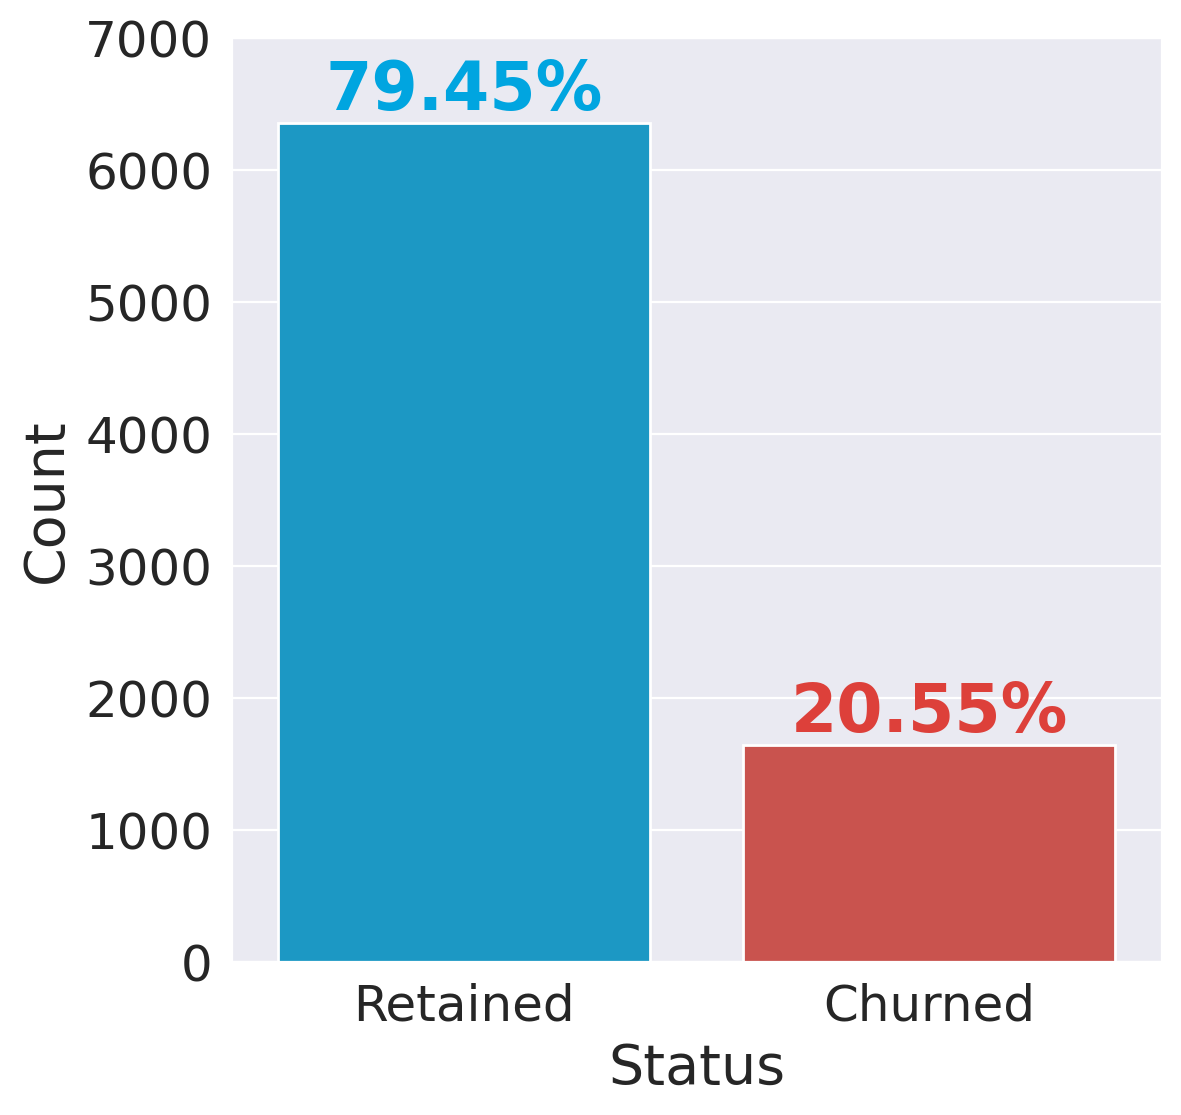

In [ ]:

fig, ax = plt.subplots(figsize=(6, 6))

sns.countplot(x='Exited', data=train_df, palette=colors, ax=ax)

for index, value in enumerate(train_df['Exited'].value_counts()):
    label = '{}%'.format(round((value / train_df['Exited'].shape[0]) * 100, 2))
    ax.annotate(label,
                xy=(index, value + 250),
                ha='center',
                va='center',
                color=colors[index],
                fontweight='bold',
                size=font_size + 4)

ax.set_xticklabels(['Retained', 'Churned'])
ax.set_xlabel('Status')
ax.set_ylabel('Count')
ax.set_ylim([0, 7000]);


In [ ]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

print('Continuous: ', ', '.join(continuous))
print('Categorical: ', ', '.join(categorical))

Continuous:  Age, CreditScore, Balance, EstimatedSalary
Categorical:  Geography, Gender, Tenure, NumOfProducts, HasCrCard, IsActiveMember


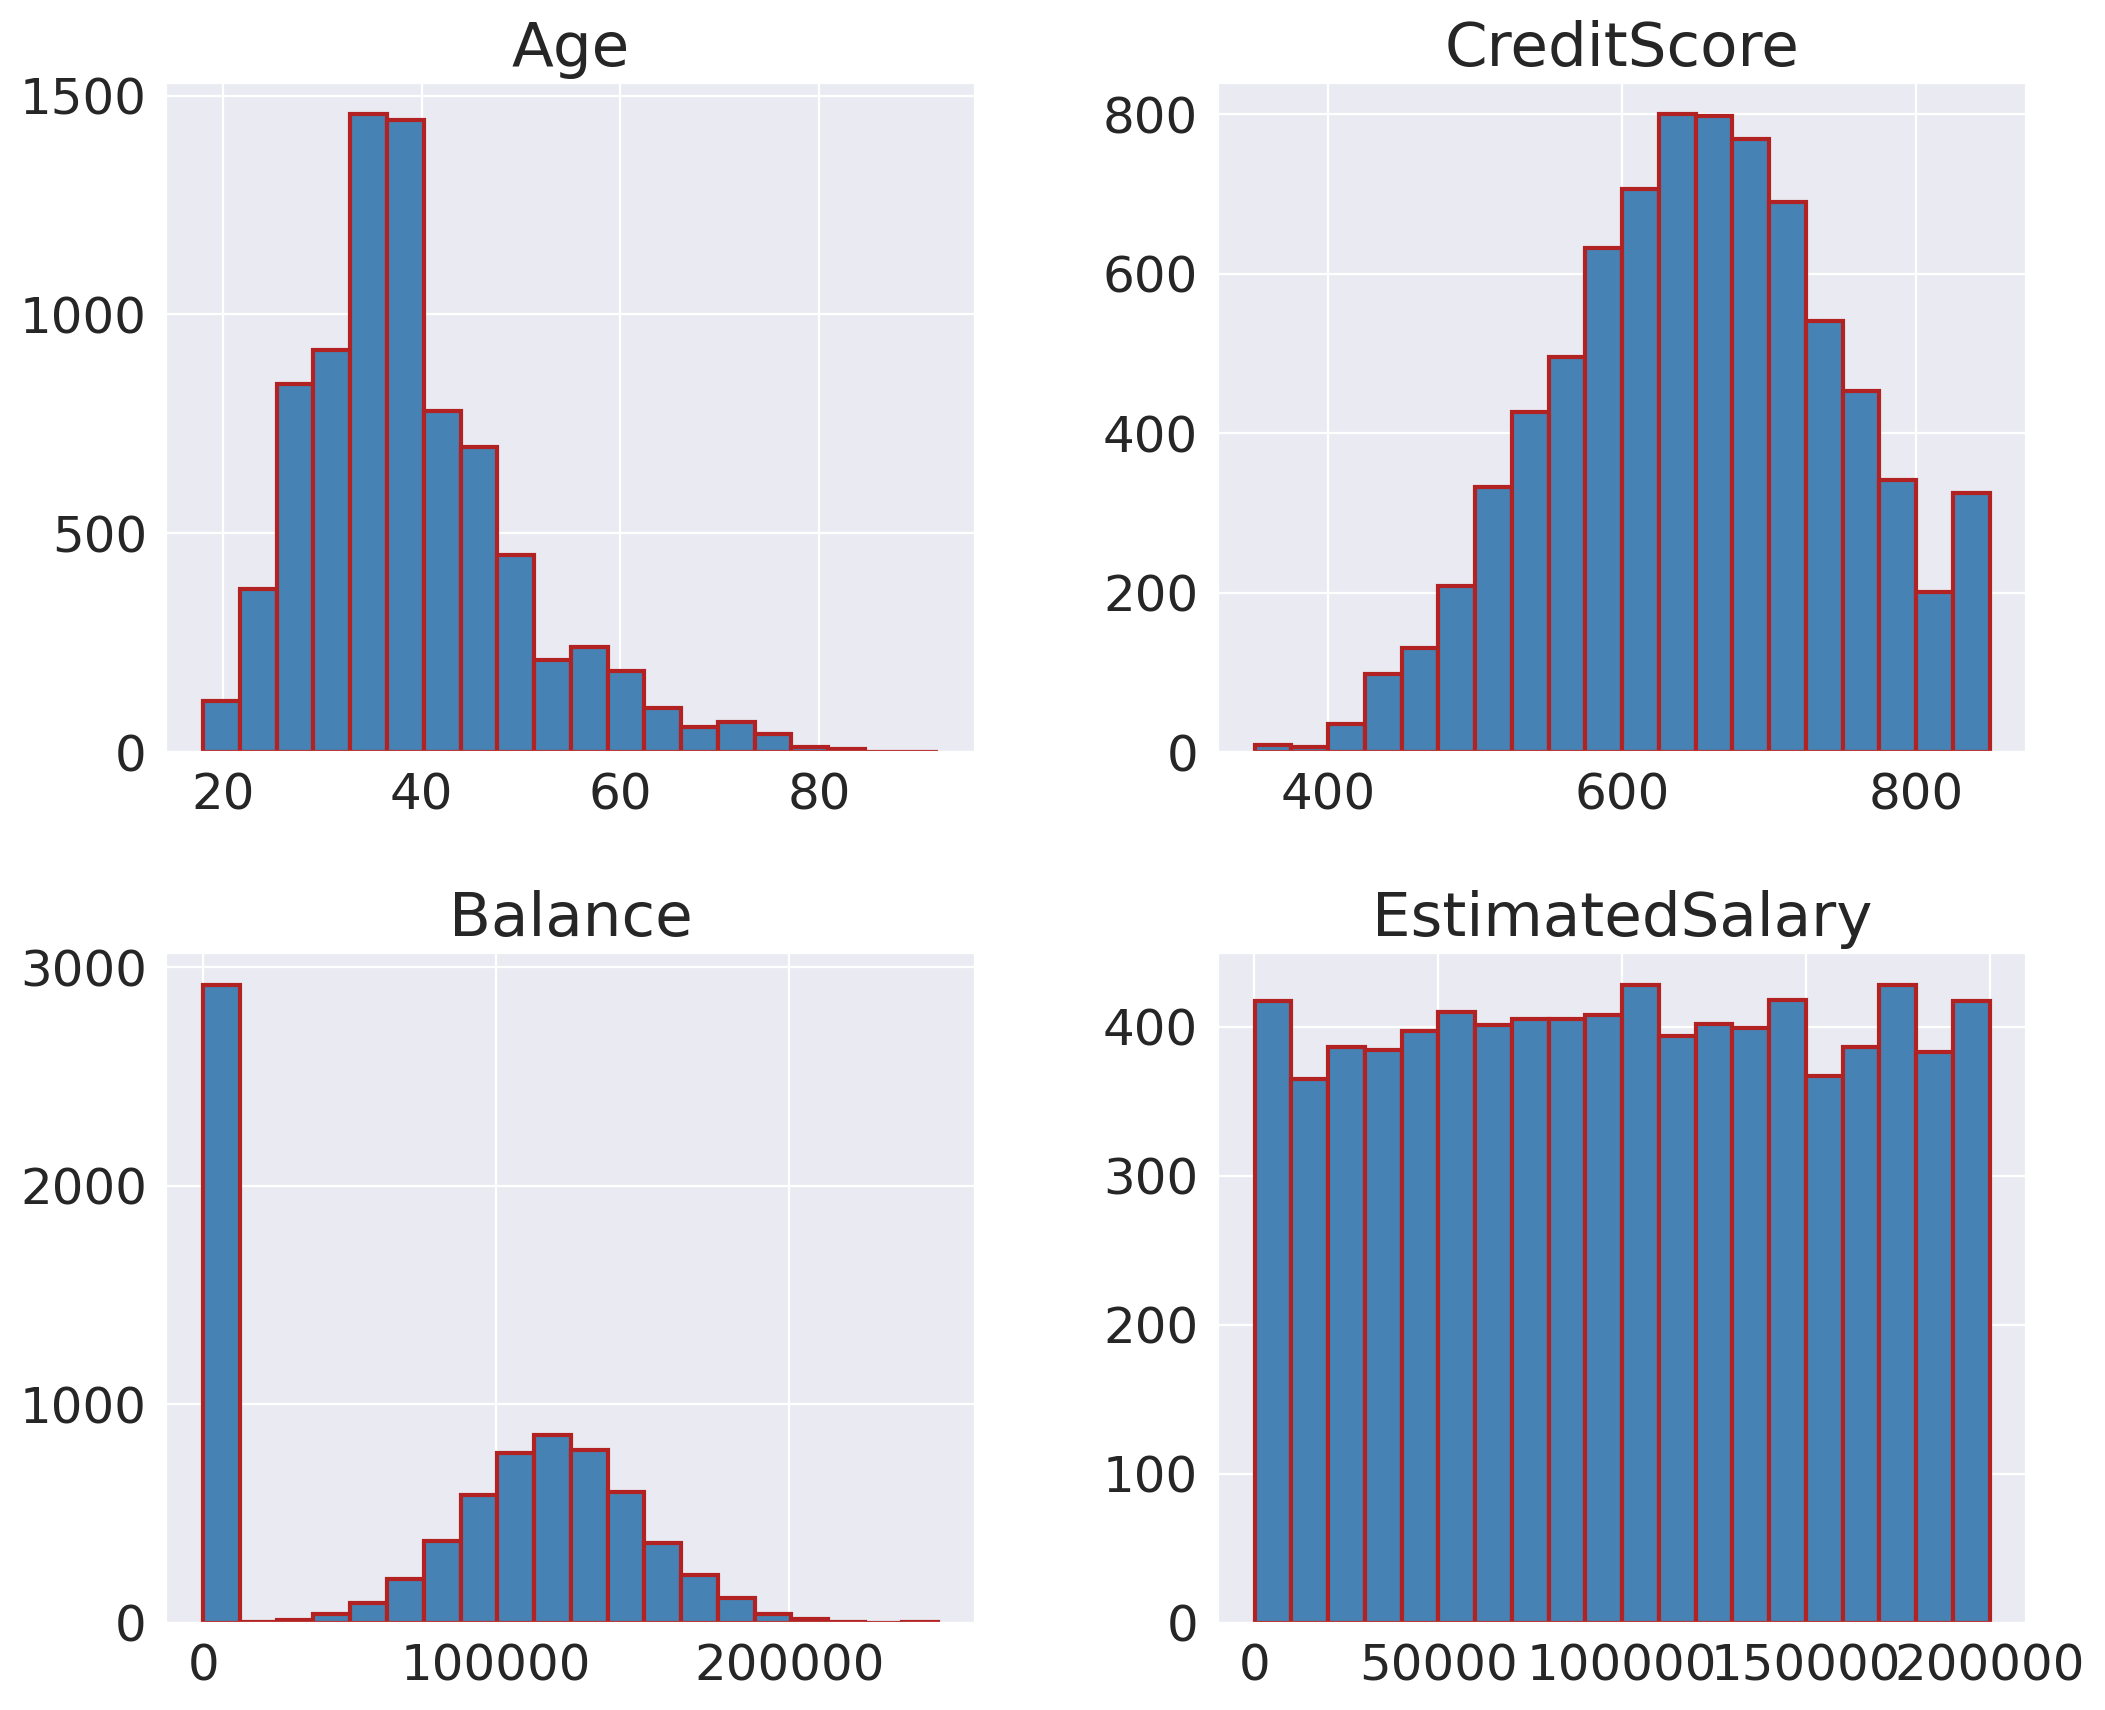

In [ ]:

train_df[continuous].hist(figsize=(12, 10),
                          bins=20,
                          layout=(2, 2),
                          color='steelblue',
                          edgecolor='firebrick',
                          linewidth=1.5);

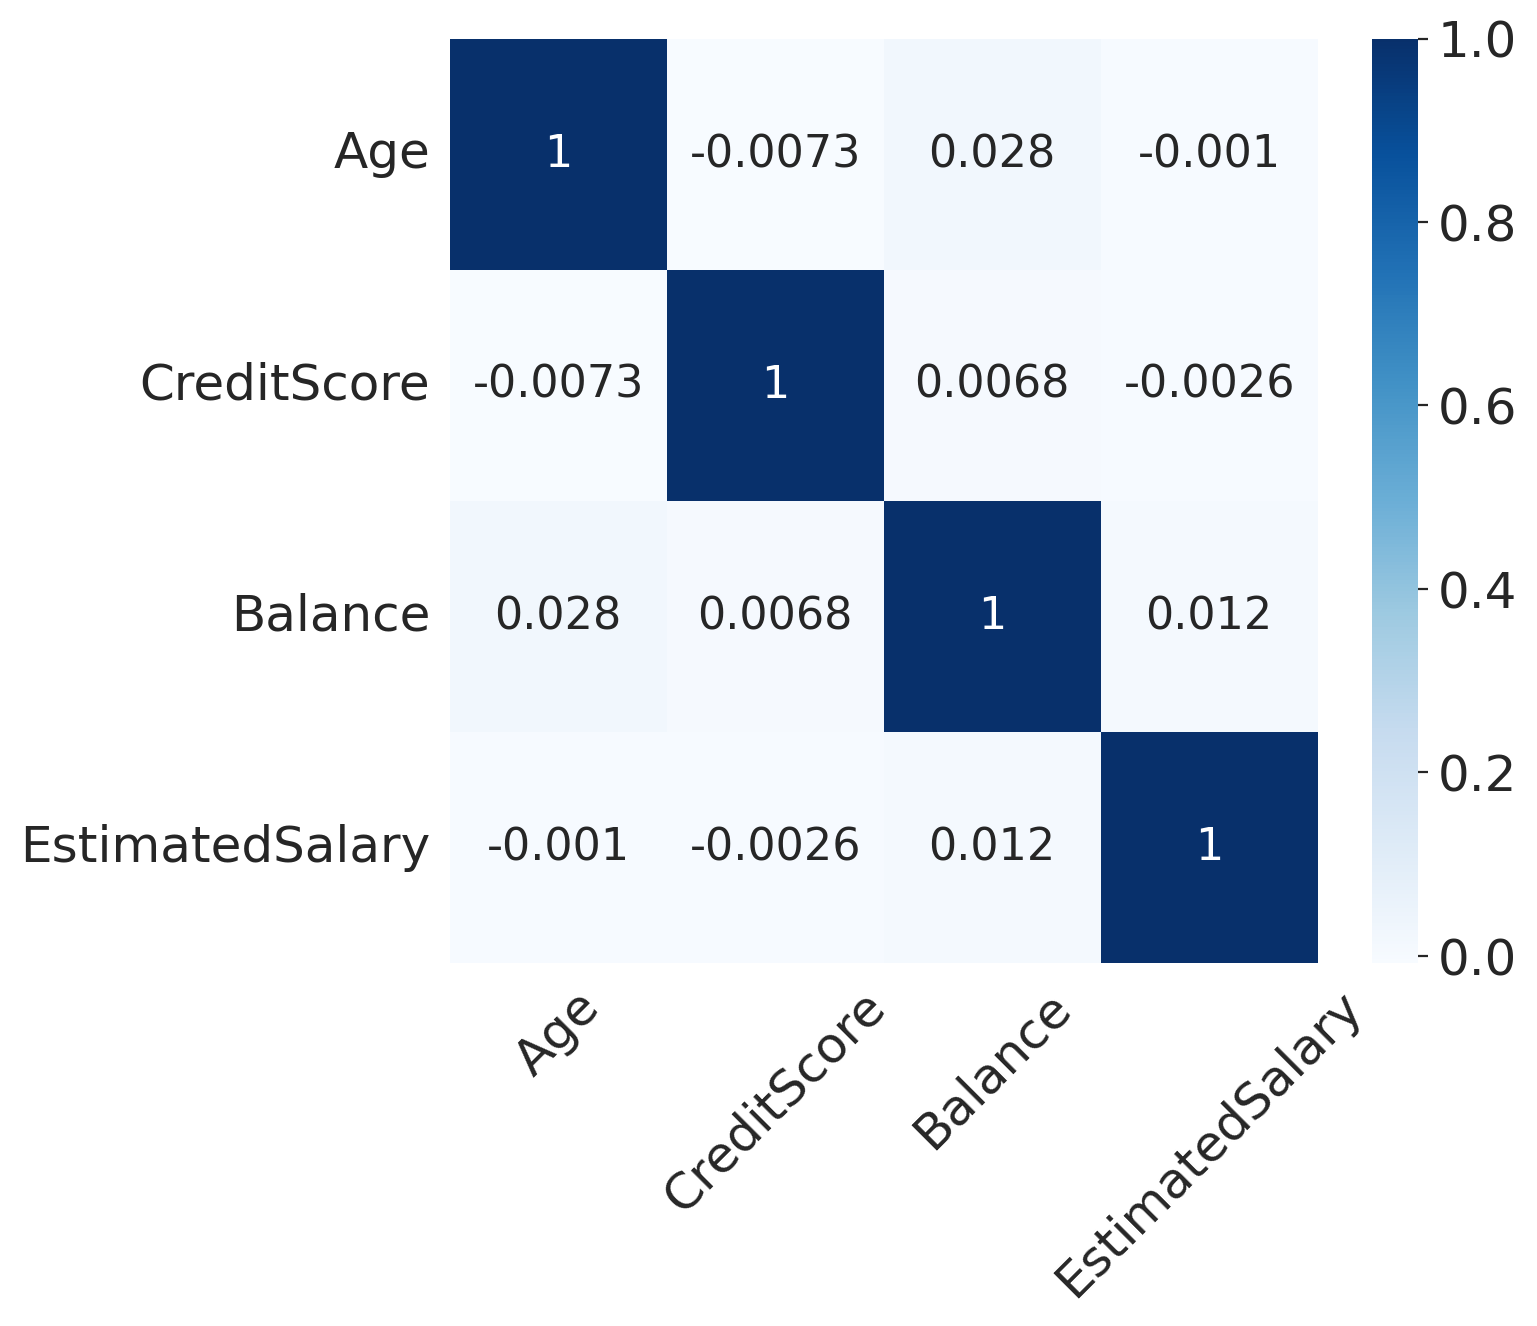

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(train_df[continuous].corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

<ipython-input-4-942a9264b999>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['Retained', 'Churned'])


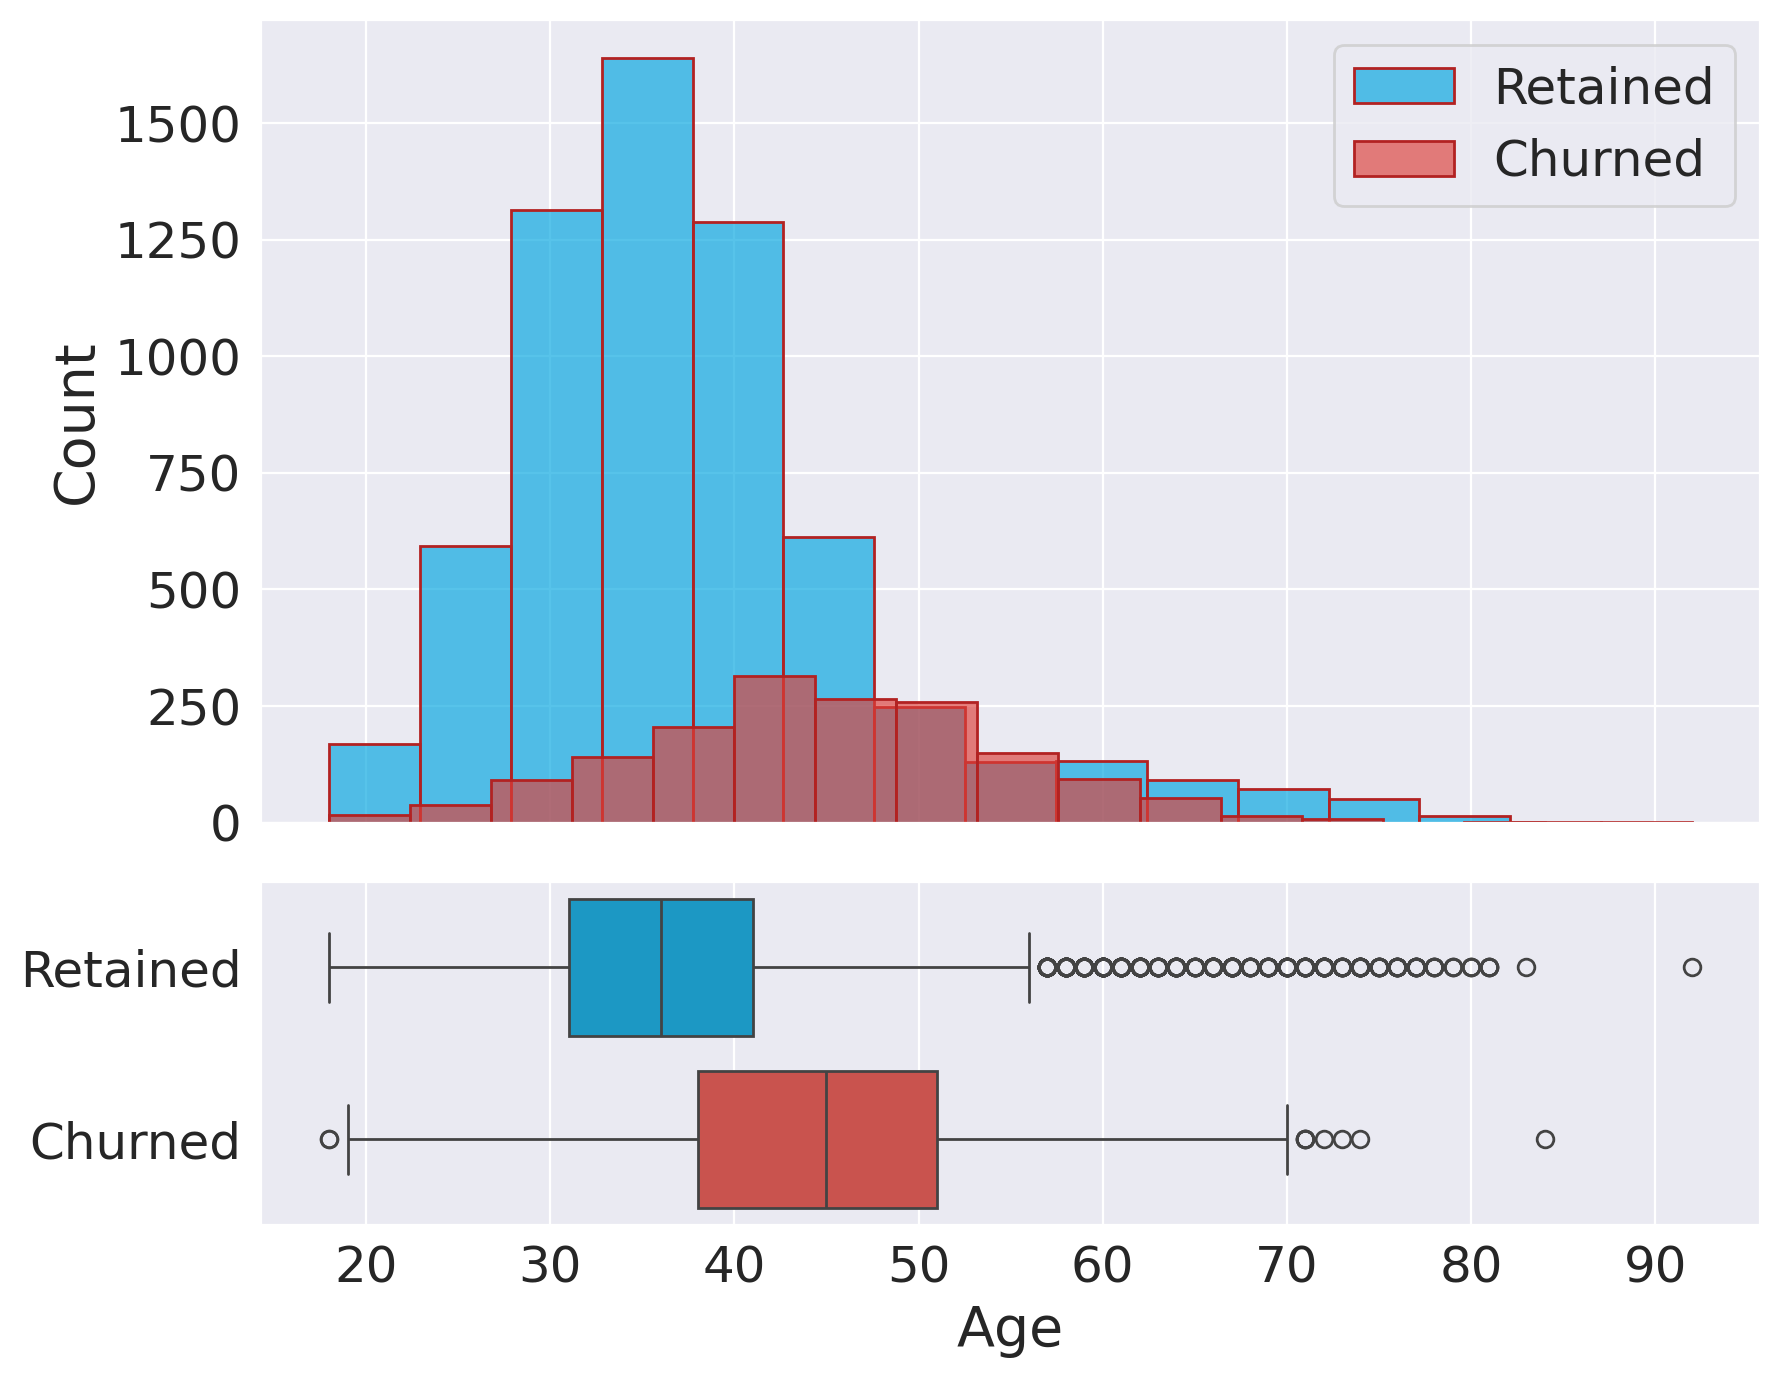

In [ ]:
df_churned = train_df[train_df['Exited'] == 1]
df_retained = train_df[train_df['Exited'] == 0]

plot_continuous('Age')

<ipython-input-4-942a9264b999>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['Retained', 'Churned'])


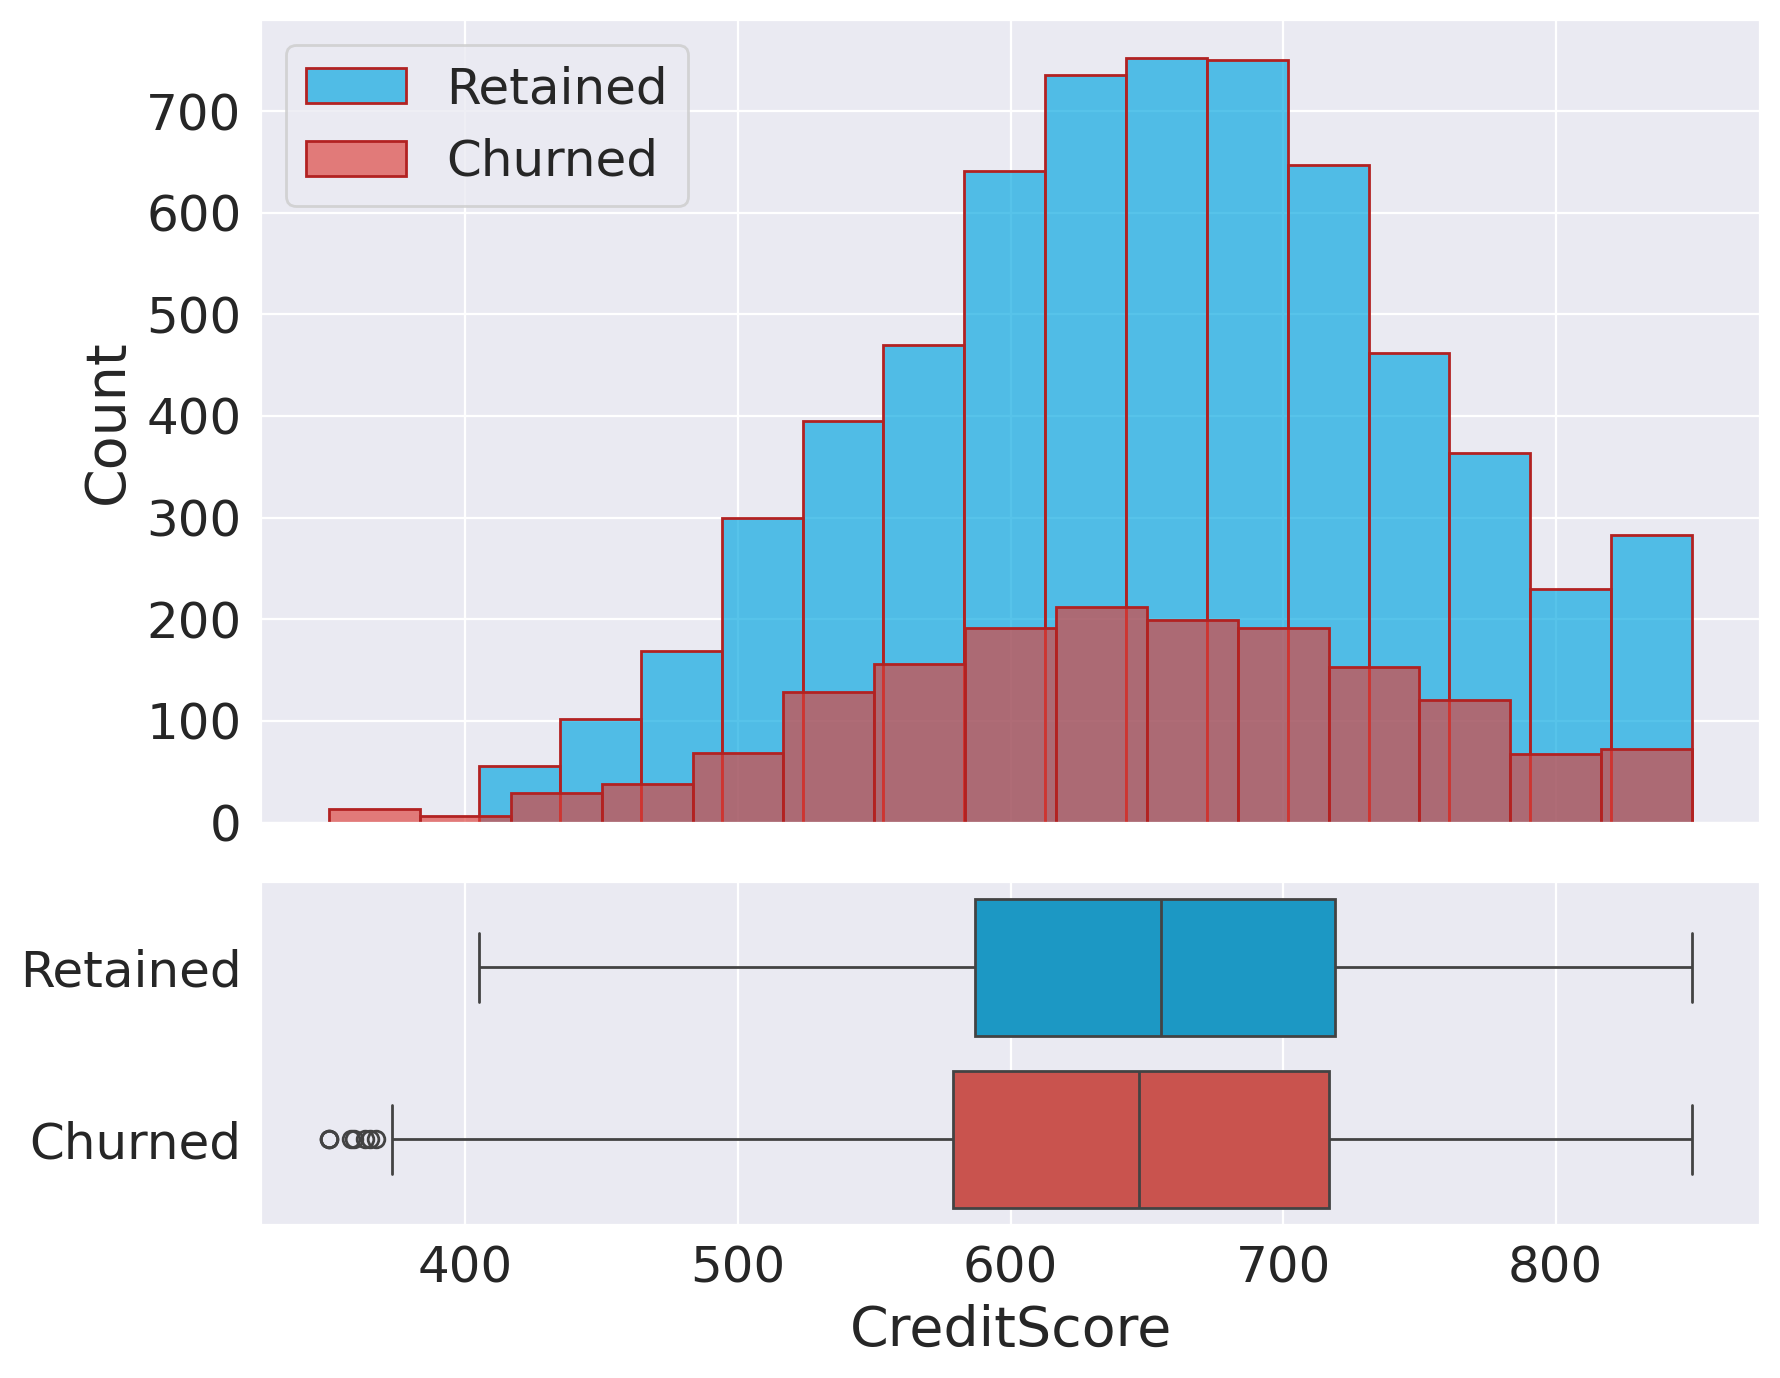

In [ ]:
plot_continuous('CreditScore')

<ipython-input-4-942a9264b999>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['Retained', 'Churned'])


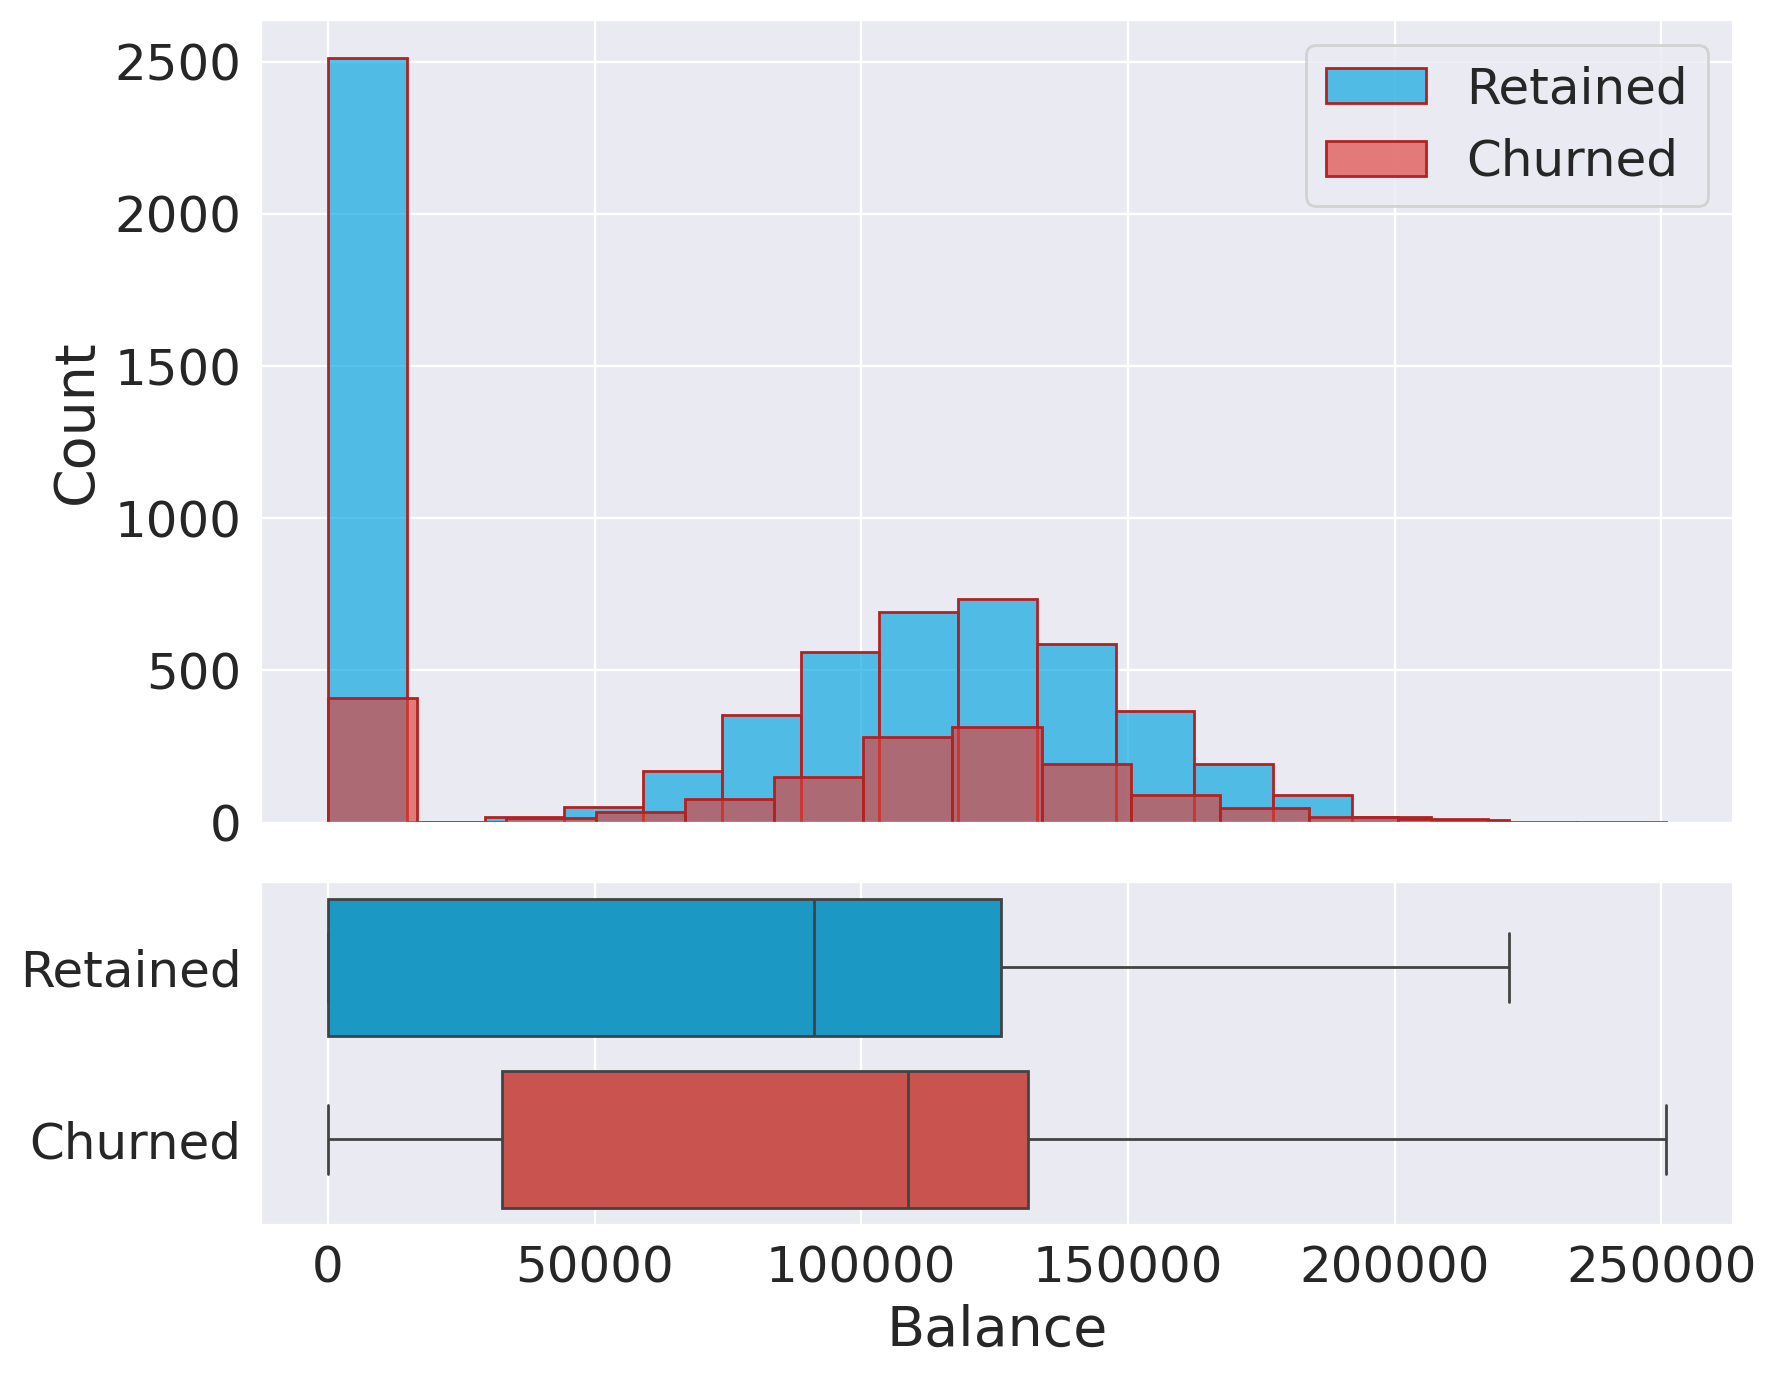

In [ ]:
plot_continuous('Balance')

<ipython-input-4-942a9264b999>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['Retained', 'Churned'])


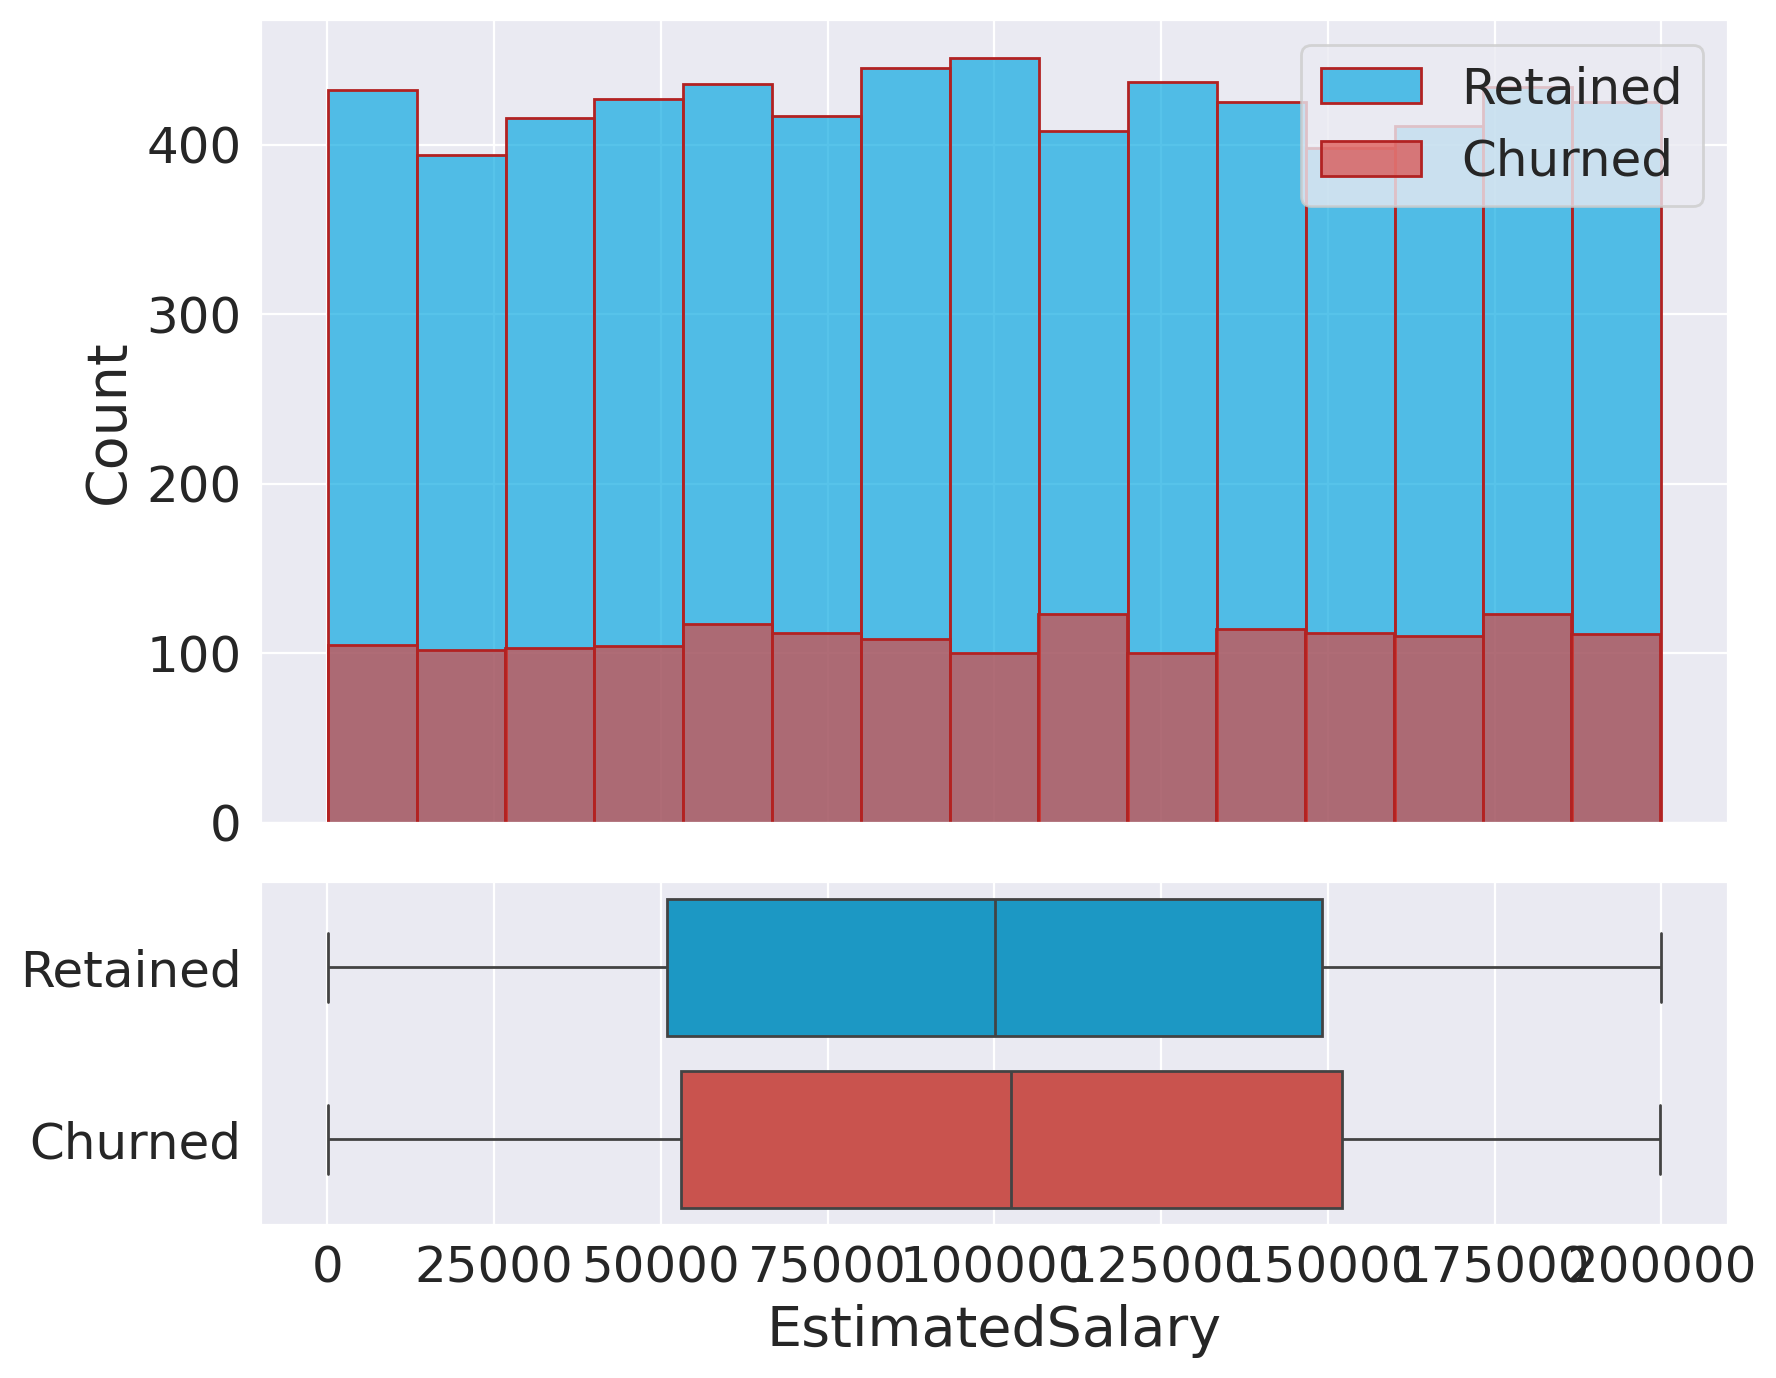

In [ ]:
plot_continuous('EstimatedSalary')

<ipython-input-25-8fcd12c181bb>:8: UserWarning: The palette list has more values (11) than needed (3), which may not be intended.
  sns.countplot(x=column, data=train_df, palette=colors_cat)
<ipython-input-25-8fcd12c181bb>:8: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  sns.countplot(x=column, data=train_df, palette=colors_cat)
<ipython-input-25-8fcd12c181bb>:8: UserWarning: The palette list has more values (11) than needed (4), which may not be intended.
  sns.countplot(x=column, data=train_df, palette=colors_cat)
<ipython-input-25-8fcd12c181bb>:8: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  sns.countplot(x=column, data=train_df, palette=colors_cat)
<ipython-input-25-8fcd12c181bb>:8: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  sns.countplot(x=column, data=train_df, palette=colors_cat)


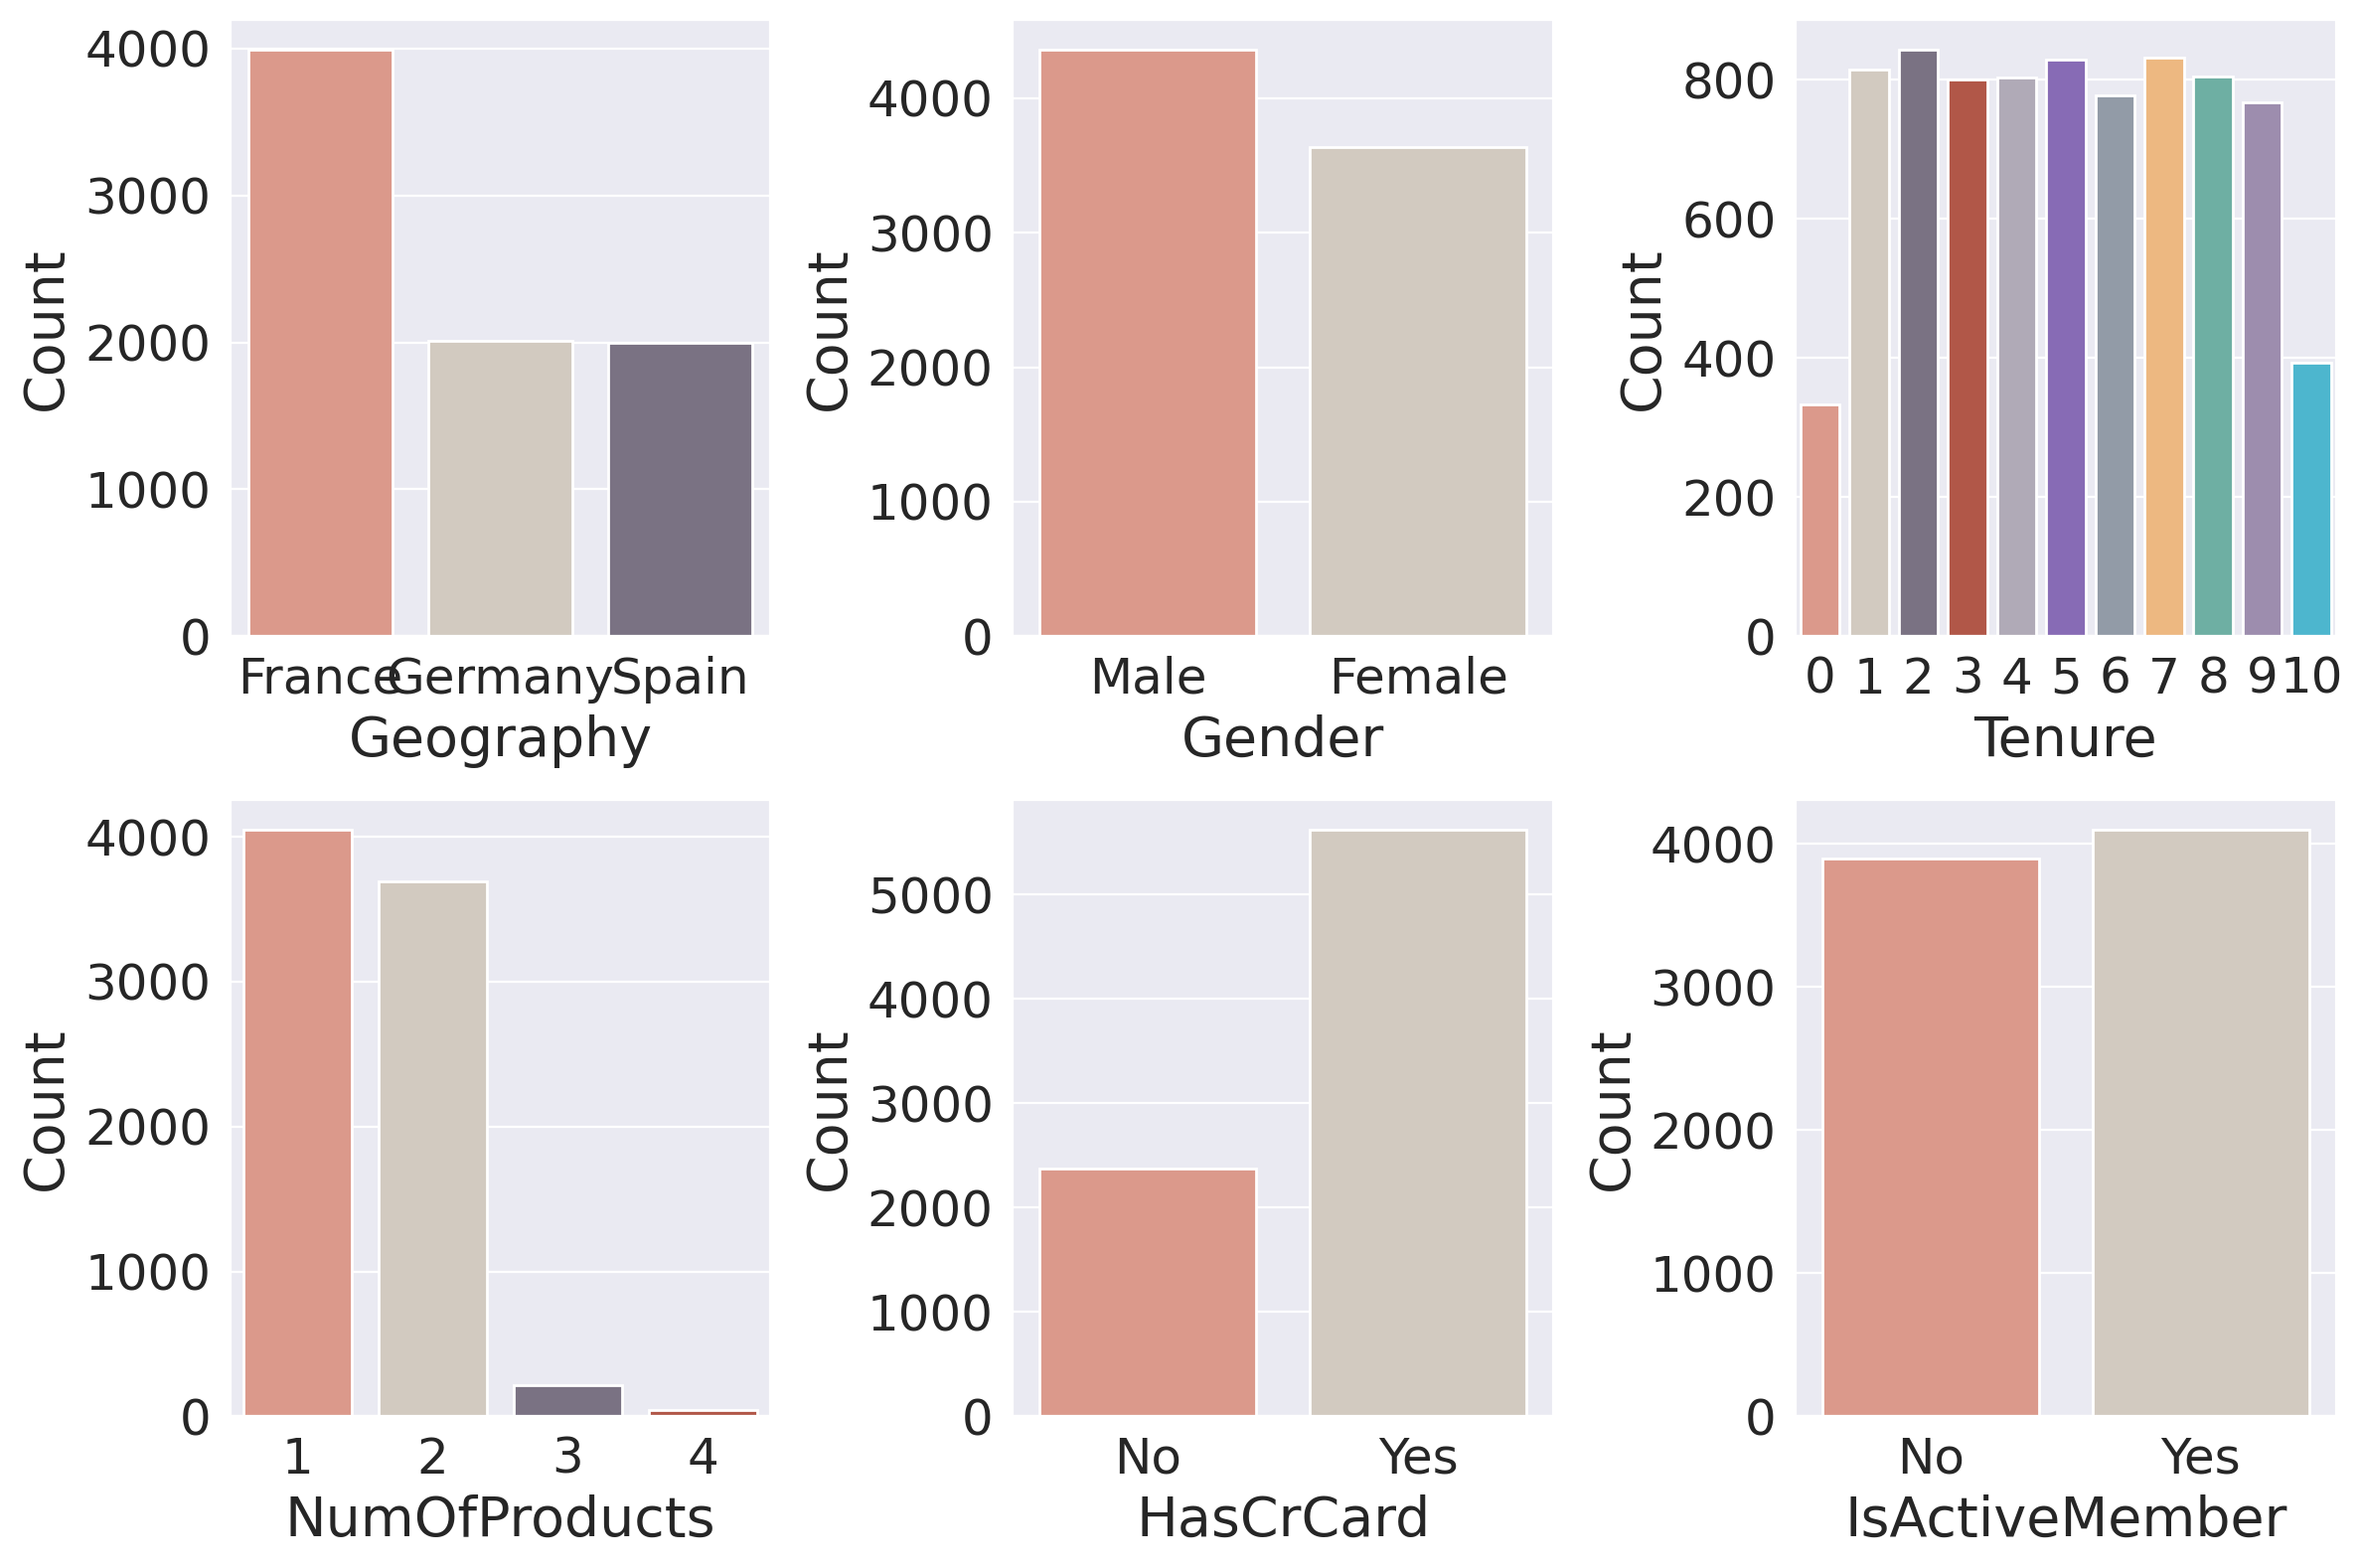

In [ ]:

df_cat = train_df[categorical]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for index, column in enumerate(df_cat.columns):

    plt.subplot(2, 3, index + 1)
    sns.countplot(x=column, data=train_df, palette=colors_cat)

    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'):
        plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout();

<ipython-input-5-bffbe343df06>:13: UserWarning: The palette list has more values (11) than needed (3), which may not be intended.
  sns.barplot(x=feature,


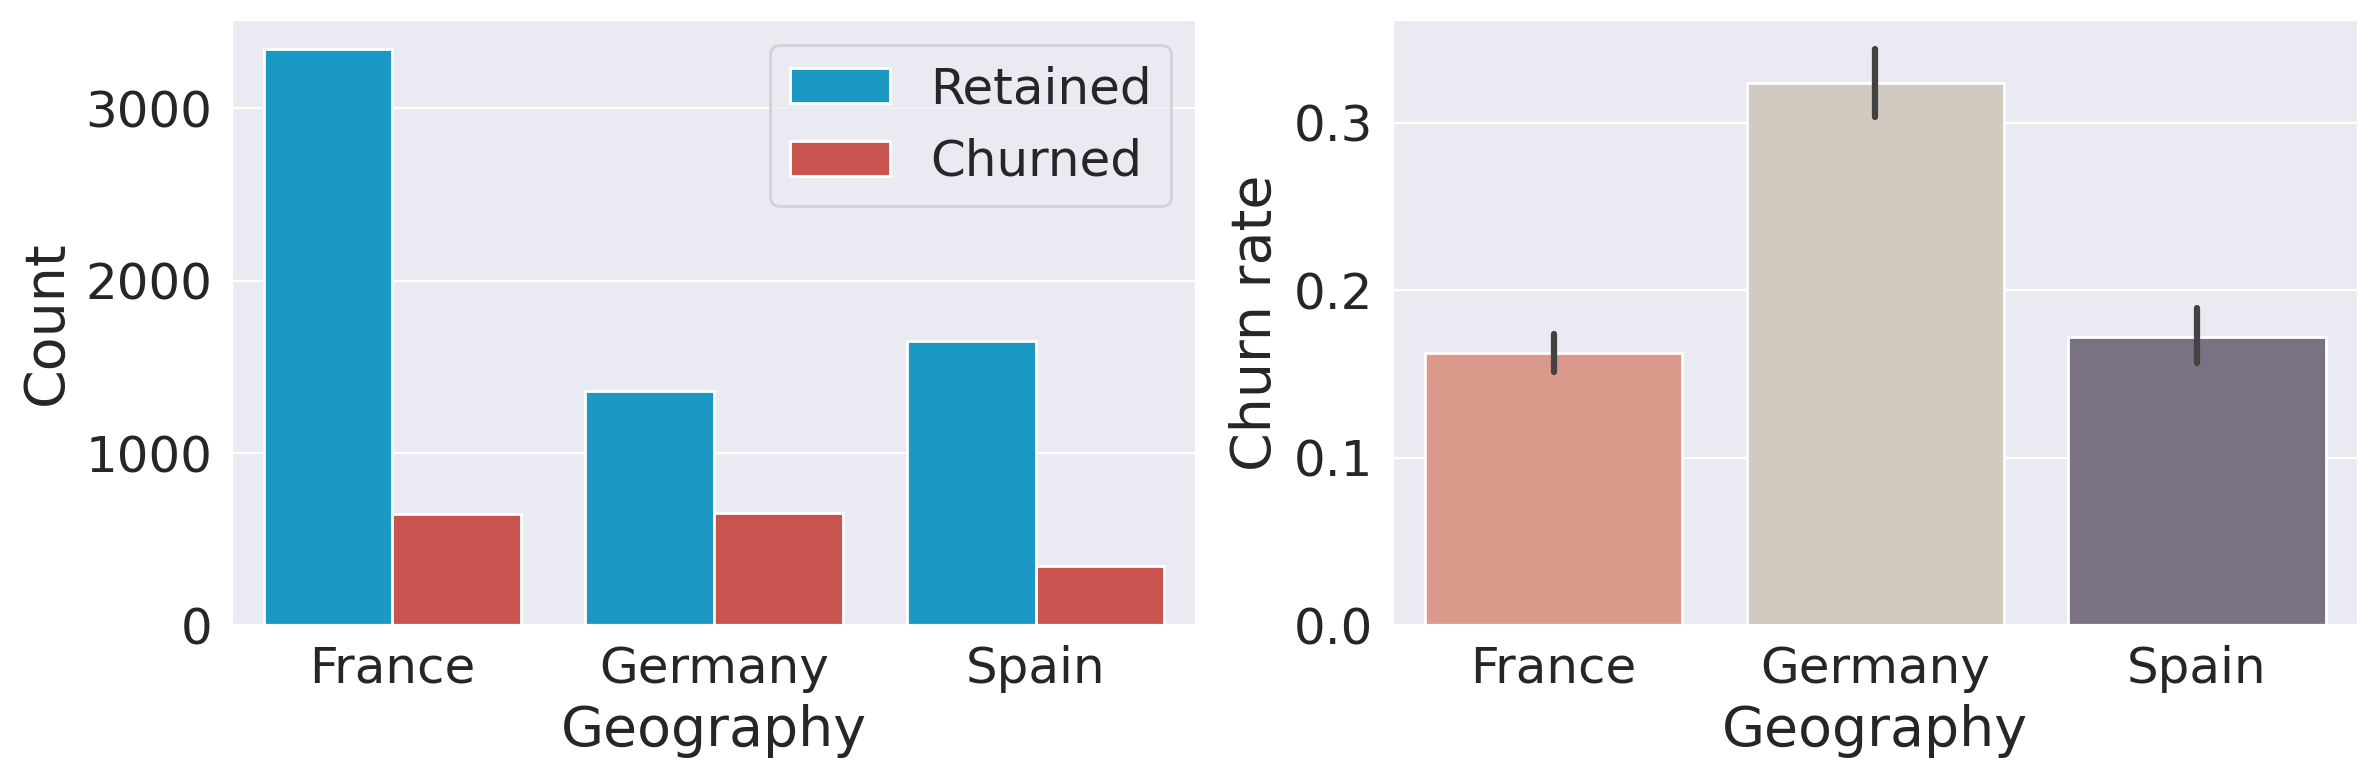

In [ ]:
plot_categorical('Geography')

<ipython-input-5-bffbe343df06>:13: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  sns.barplot(x=feature,


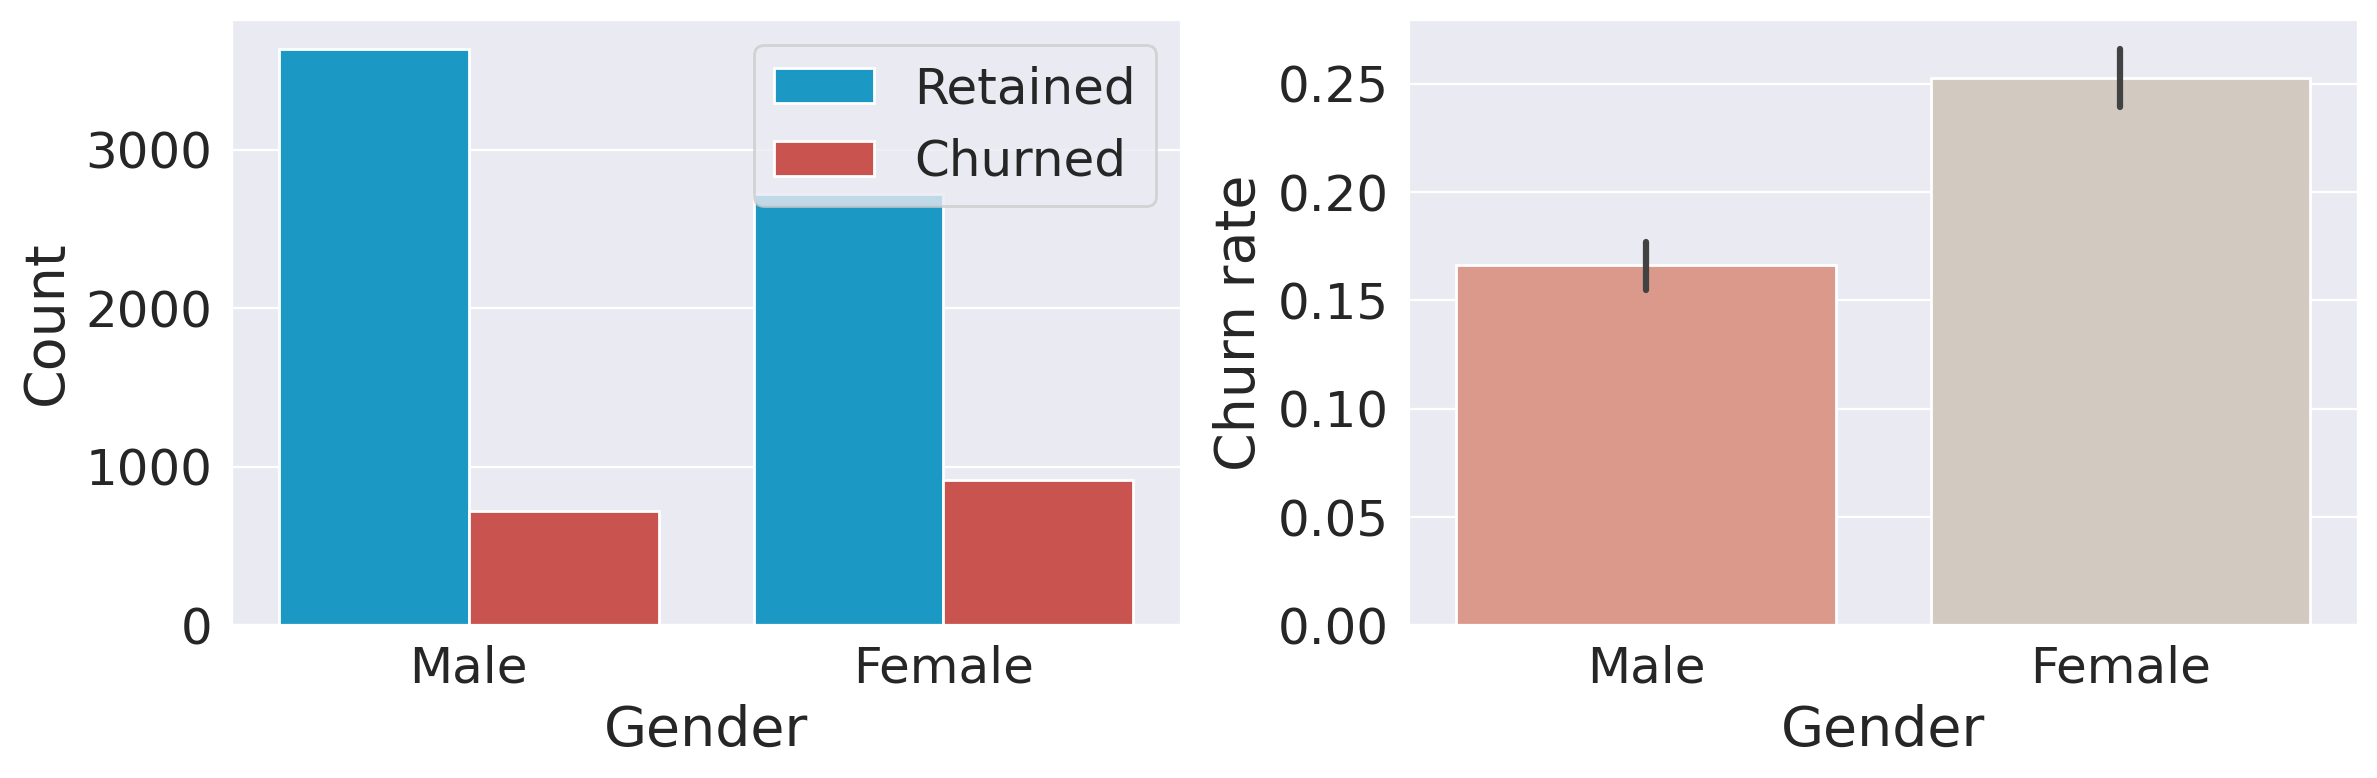

In [ ]:
plot_categorical('Gender')

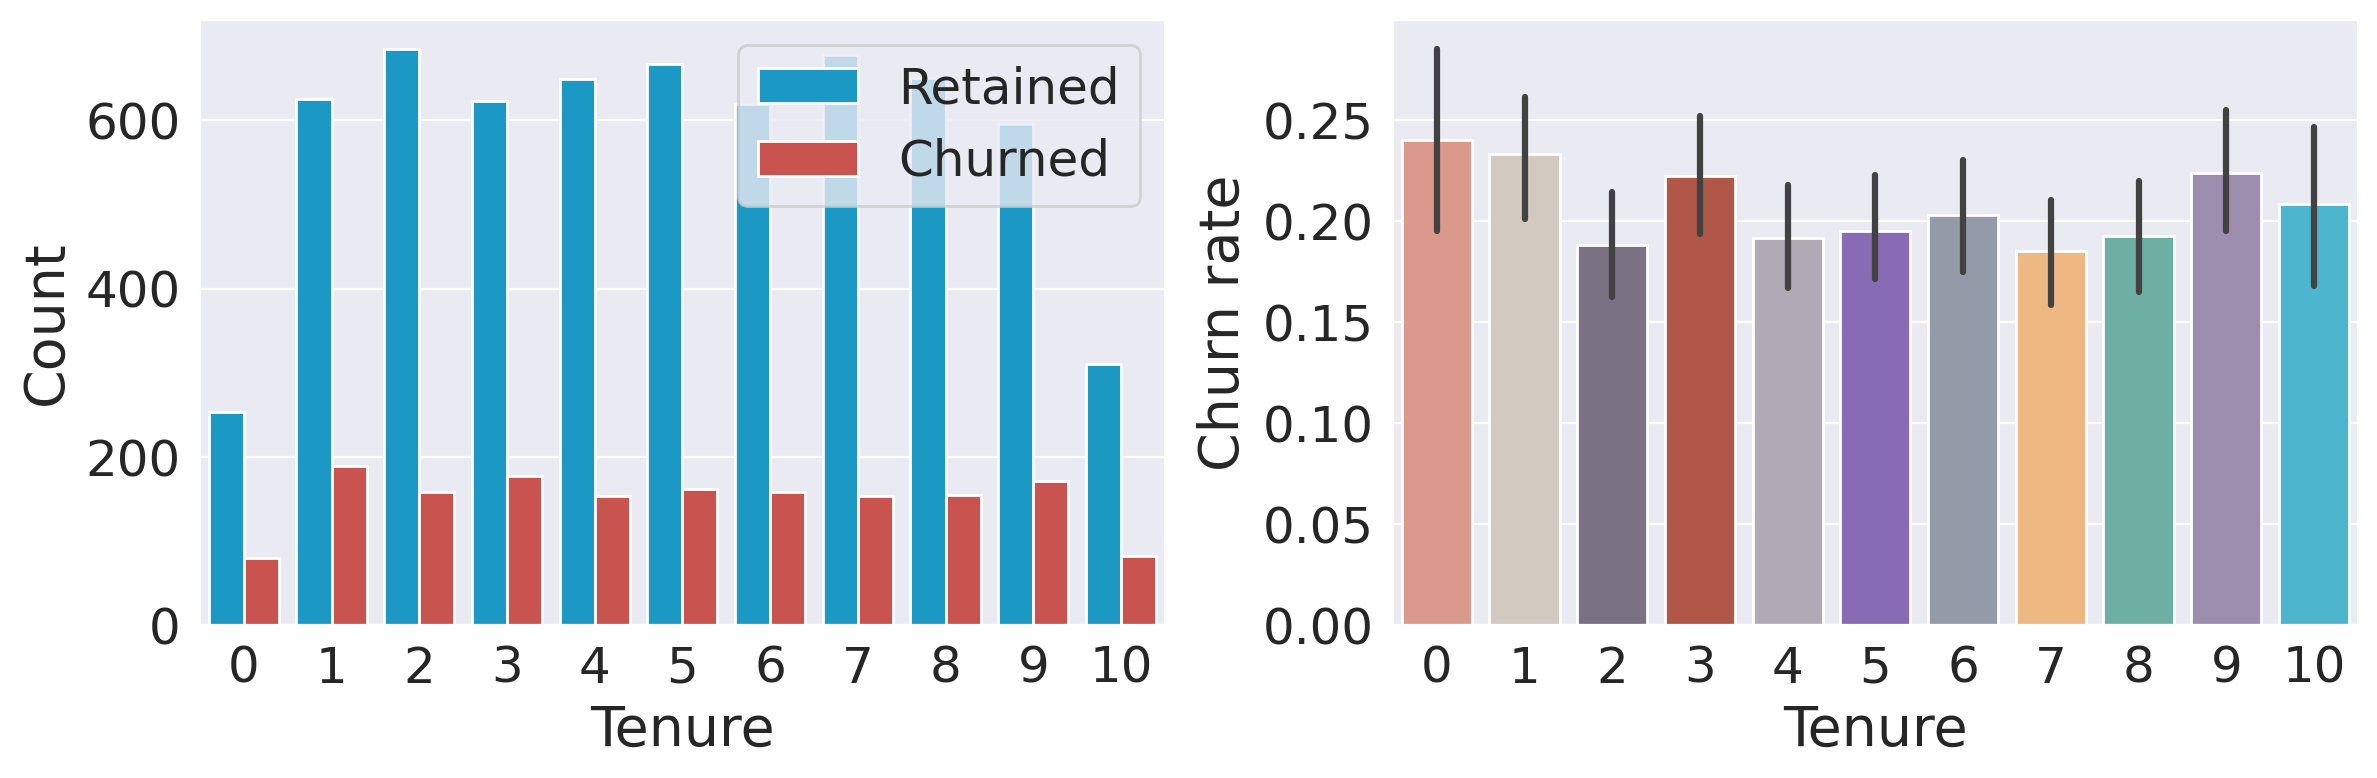

In [ ]:
plot_categorical('Tenure')

<ipython-input-5-bffbe343df06>:13: UserWarning: The palette list has more values (11) than needed (4), which may not be intended.
  sns.barplot(x=feature,


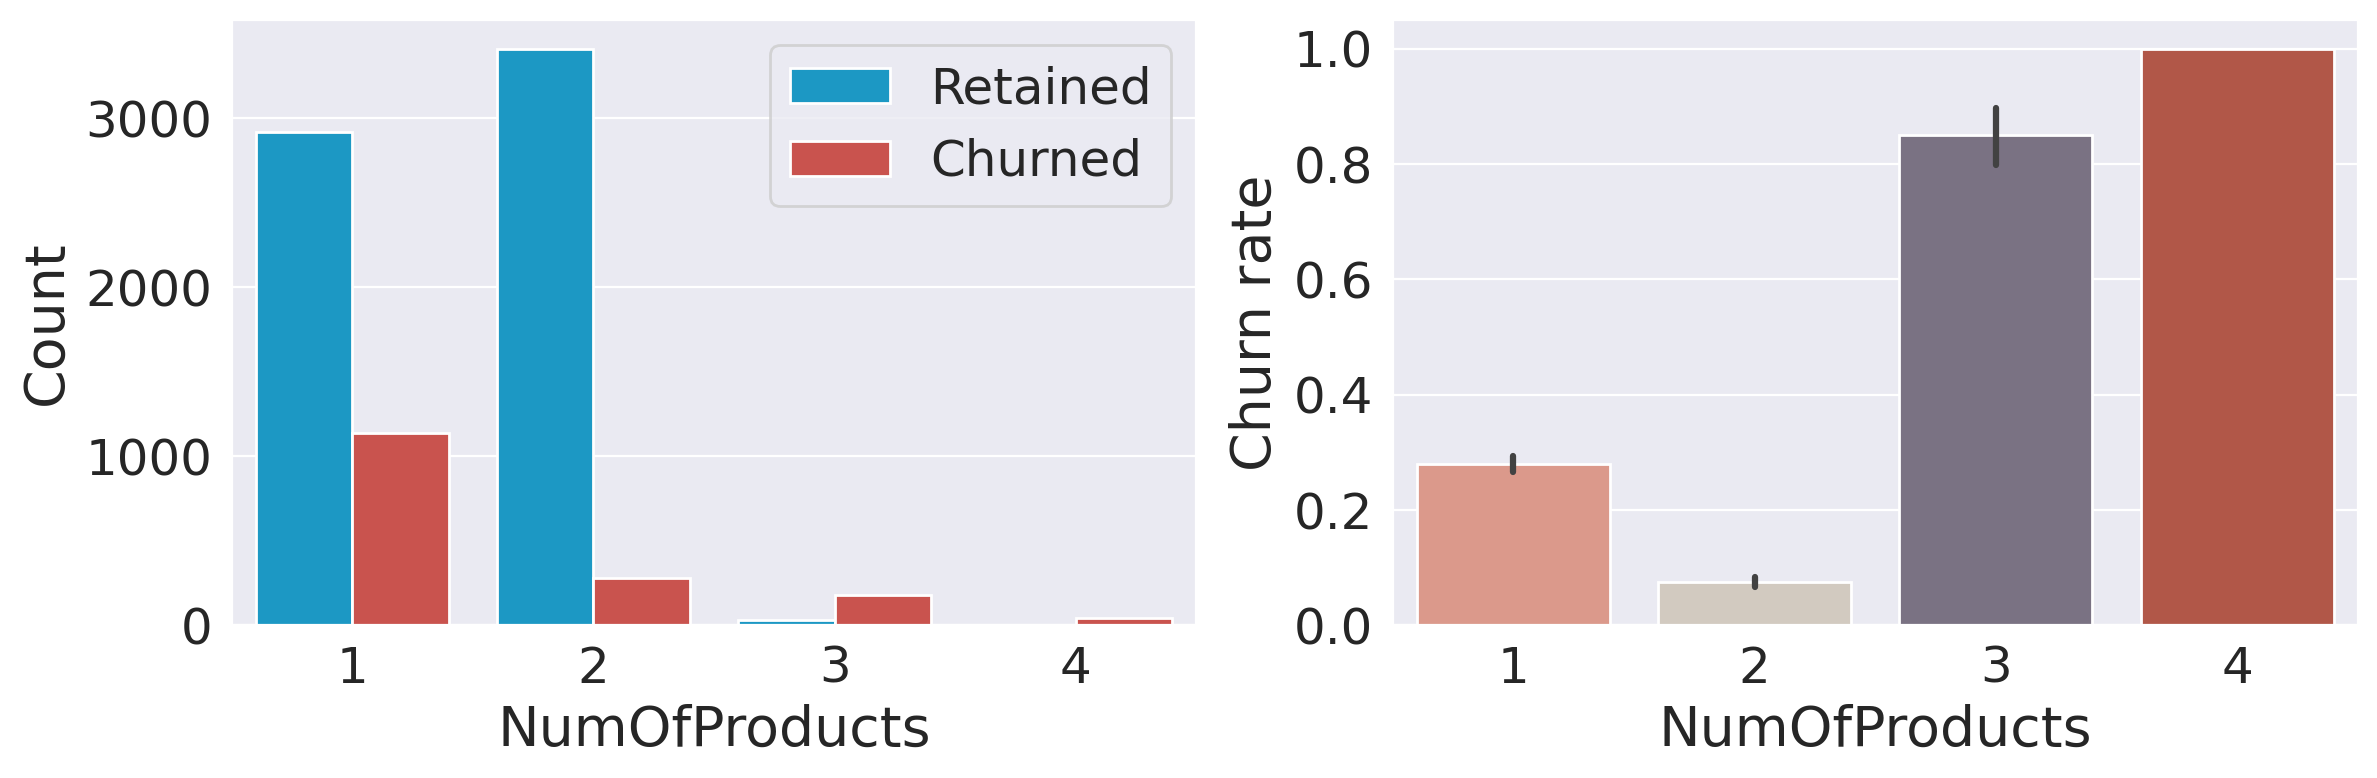

In [ ]:
plot_categorical('NumOfProducts')

<ipython-input-5-bffbe343df06>:13: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  sns.barplot(x=feature,
<ipython-input-5-bffbe343df06>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['No', 'Yes'])
<ipython-input-5-bffbe343df06>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['No', 'Yes'])


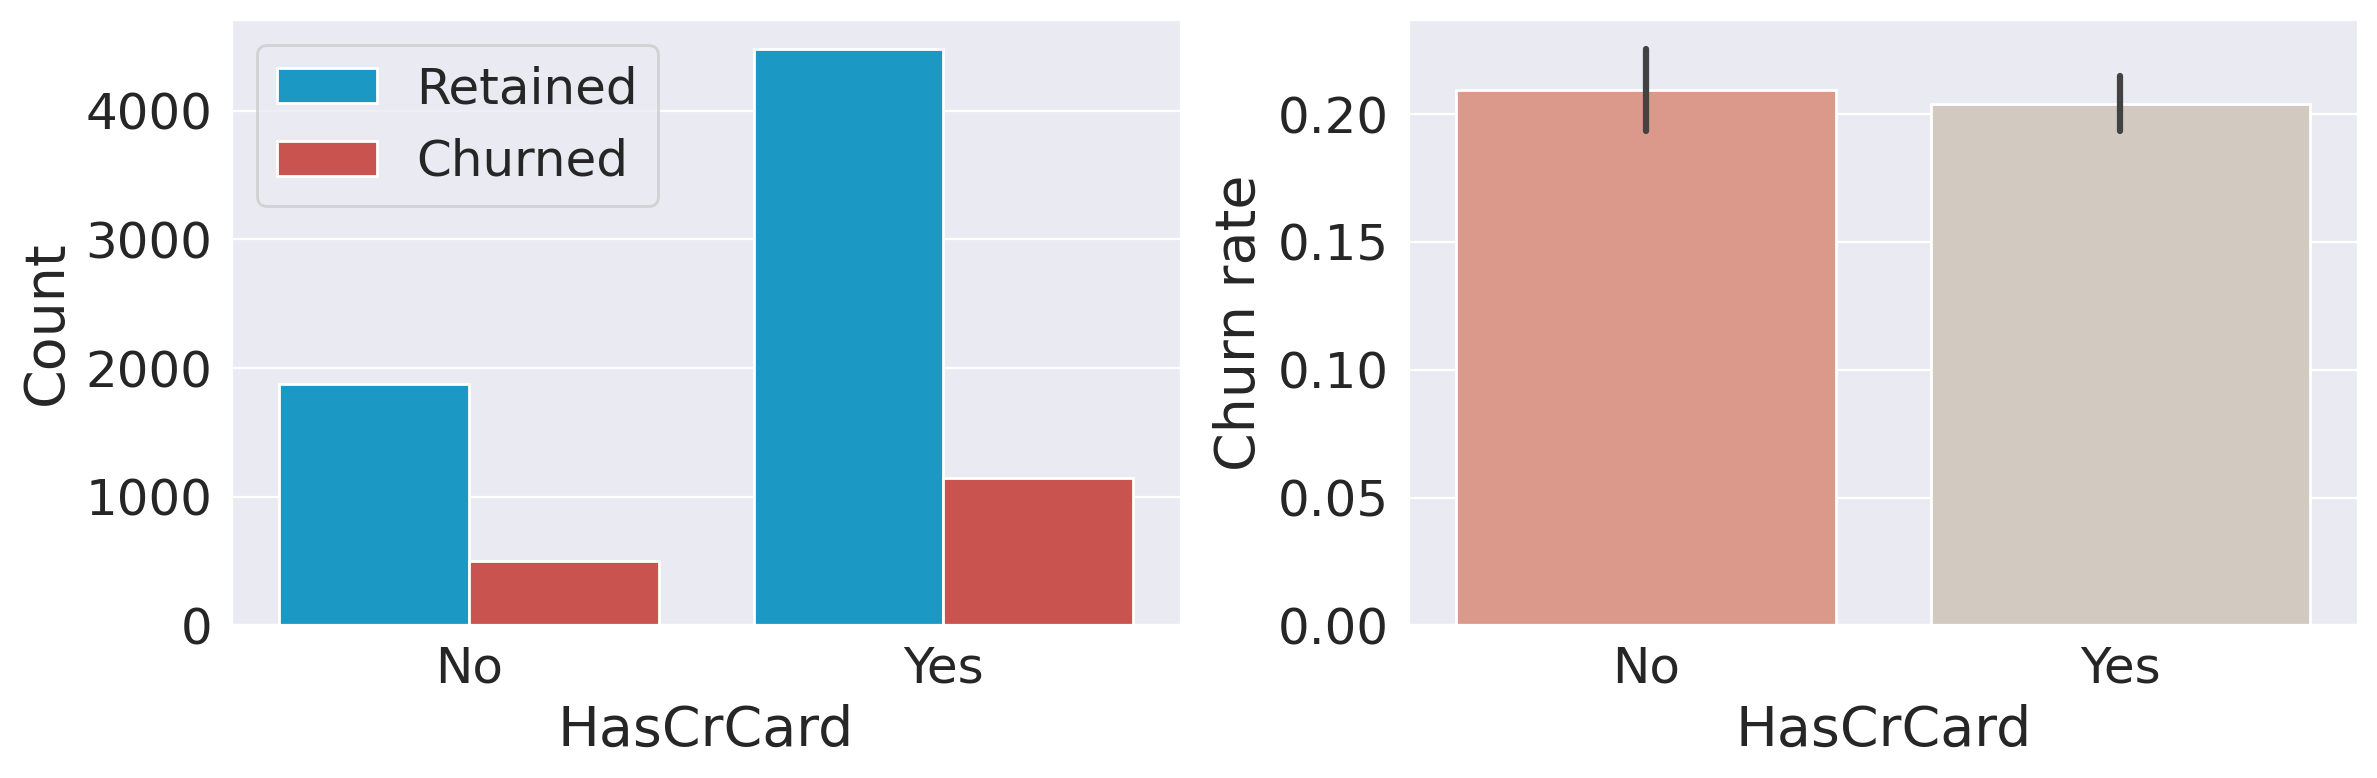

In [ ]:
plot_categorical('HasCrCard')

<ipython-input-5-bffbe343df06>:13: UserWarning: The palette list has more values (11) than needed (2), which may not be intended.
  sns.barplot(x=feature,
<ipython-input-5-bffbe343df06>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['No', 'Yes'])
<ipython-input-5-bffbe343df06>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['No', 'Yes'])


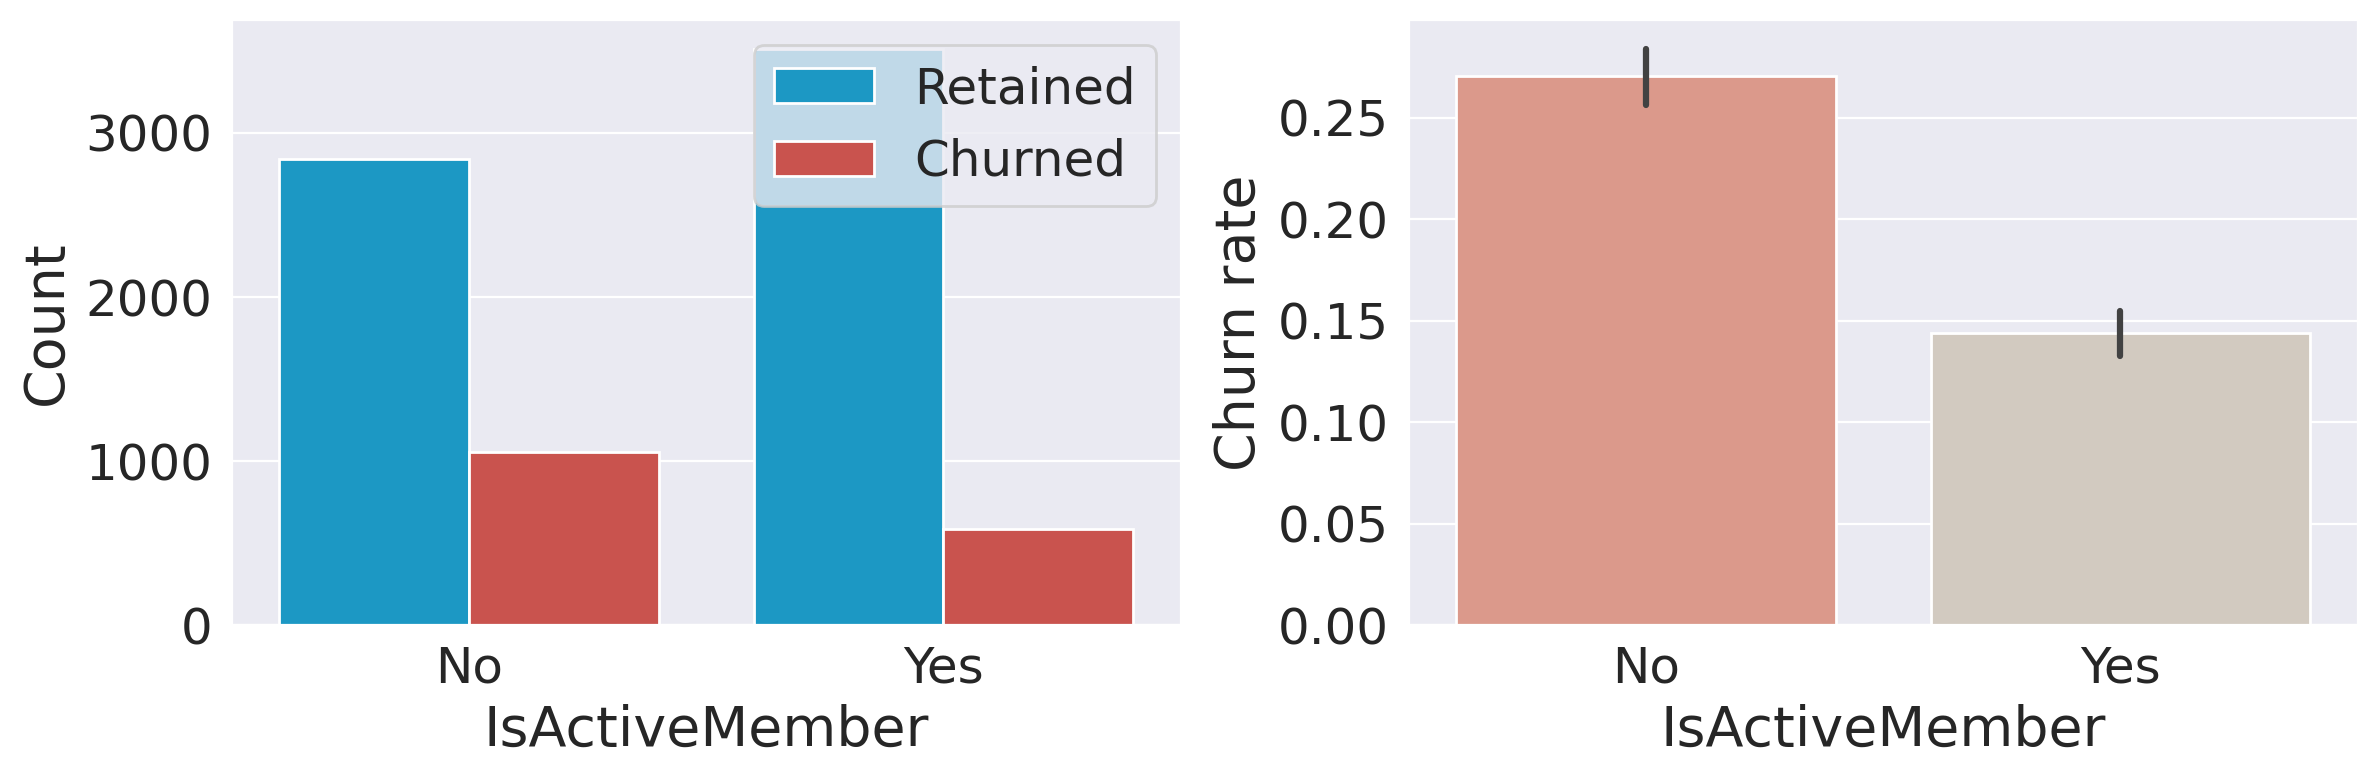

In [ ]:
plot_categorical('IsActiveMember')

In [ ]:
chi2_array, p_array = [], []
for column in categorical:

    crosstab = pd.crosstab(train_df[column], train_df['Exited'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    chi2_array.append(chi2)
    p_array.append(p)

df_chi = pd.DataFrame({
    'Variable': categorical,
    'Chi-square': chi2_array,
    'p-value': p_array
})
df_chi.sort_values(by='Chi-square', ascending=False)

,Variable,Chi-square,p-value
3,NumOfProducts,1233.595,0.000
0,Geography,230.748,0.000
5,IsActiveMember,195.315,0.000
1,Gender,90.173,0.000
2,Tenure,15.197,0.125
4,HasCrCard,0.301,0.583


In [ ]:
features_drop = ['Tenure', 'HasCrCard', 'EstimatedSalary']
train_df = train_df.drop(features_drop, axis=1)

print('✔️ Features Dropped!')

✔️ Features Dropped!


In [ ]:

train_df['Gender'] = LabelEncoder().fit_transform(train_df['Gender'])

train_df['Geography'] = train_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0
})

print('✔️ Features Encoded!')

✔️ Features Encoded!


In [ ]:
scaler = StandardScaler()

scl_columns = ['CreditScore', 'Age', 'Balance']
train_df[scl_columns] = scaler.fit_transform(train_df[scl_columns])

print('✔️ Features Scaled!')

✔️ Features Scaled!


In [ ]:
y_train = train_df['Exited']
x_train = train_df.drop('Exited', axis=1)

print('✔️ Sets Created!')


✔️ Sets Created!


In [ ]:
y_train.value_counts()

,count
Exited,
0,6356
1,1644


In [ ]:
over = SMOTE(sampling_strategy='auto', random_state=random_state)

# Resample the training data
x_train_resampled, y_train_resampled = over.fit_resample(x_train, y_train)

# Check the new class distribution
print(y_train_resampled.value_counts())

Exited
0    6356
1    6356
Name: count, dtype: int64


In [ ]:


# Define the scoring metric (e.g., 'recall')
scoring_metric = 'recall'

# Ensure you have x_train and y_train from earlier (e.g., after applying SMOTE)
# clf_list with classifiers
clf_list = [('Gaussian Naive Bayes', GaussianNB()),
            ('Logistic Regression', LogisticRegression(random_state=random_state))]

# Lists to store the mean and std of cross-validation scores
cv_base_mean, cv_std = [], []

# Perform cross-validation for each classifier
for clf in clf_list:
    cv = cross_val_score(estimator=clf[1],
                         x=x_train,
                         y=y_train,
                         scoring=scoring_metric,
                         cv=5,
                         n_jobs=-1)  # -1 uses all processors

    # Append mean and std of cross-validation scores
    cv_base_mean.append(cv.mean())
    cv_std.append(cv.std())

# Print results
print('Baseline Models (Recall):')
for i in range(len(clf_list)):
    print(f'   {clf_list[i][0]}: Mean Recall: {np.round(cv_base_mean[i], 2)}, Std: {np.round(cv_std[i], 2)}')


Baseline Models (Recall):
   Gaussian Naive Bayes: Mean Recall: 0.33, Std: 0.02
   Logistic Regression: Mean Recall: 0.22, Std: 0.04
